In [106]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import h5py
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

In [132]:
def collect_data(filename):
    
    # Open the file
    with h5py.File(filename, 'r') as f:
        # locs
        locs = f['locs']
        
        x_values = locs['x'][:]
        y_values = locs['y'][:]
        
    data = {
        'x': x_values,
        'y': y_values,
    }
    
    return pd.DataFrame(data)

def collect_group_data(hdf5_file, dataset_name):
    group_data_list = []

    with h5py.File(hdf5_file, 'r') as f:
        # Access the dataset
        dataset = f[dataset_name]

        # Extract the 'group', 'x', and 'y' fields
        group_data = dataset['group'][:]
        x_data = dataset['x'][:]
        y_data = dataset['y'][:]

        # Find unique groups
        unique_groups = np.unique(group_data)

        # Collect data for each group
        for group in unique_groups:
            indices = np.where(group_data == group)
            group_dict = {
                'group': int(group),
                'x': x_data[indices].tolist(),
                'y': y_data[indices].tolist()
            }
            group_data_list.append(group_dict)
    
    return group_data_list

def find_clusters_k_means(data, k):
    kmeans = KMeans(n_clusters=k, random_state = 42 , init= 'k-means++')
    kmeans.fit(data)
    return kmeans.labels_

def find_com(data, labels):
    com = []
    for i in range(max(labels)+1):
        x = np.mean(data['x'][labels == i])
        y = np.mean(data['y'][labels == i])
        com.append((x, y))
    return com
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

def minimum_bounding_rectangle(points):
    """
    Find the smallest bounding rectangle for a set of points.
    Returns a set of points representing the corners of the bounding box.
    """
    pi2 = np.pi / 2

    # Get the convex hull for the points
    hull_points = points[ConvexHull(points).vertices]

    # Calculate edge angles
    edges = hull_points[1:] - hull_points[:-1]
    angles = np.arctan2(edges[:, 1], edges[:, 0])
    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    # Find rotation matrices
    rotations = np.vstack([
        np.cos(angles),
        np.cos(angles - pi2),
        np.cos(angles + pi2),
        np.cos(angles)
    ]).T
    rotations = rotations.reshape((-1, 2, 2))

    # Apply rotations to the hull
    rot_points = np.dot(rotations, hull_points.T)

    # Find the bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # Find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    # Return the best box
    x1, x2 = max_x[best_idx], min_x[best_idx]
    y1, y2 = max_y[best_idx], min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((4, 2))
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)

    return rval

def distance_to_line(point, line_start, line_end):
    """Calculate the perpendicular distance from a point to a line."""
    if np.all(line_start == line_end):
        return np.linalg.norm(point - line_start)
    return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))

def find_closest_side(points, rectangle):
    """Find the side of the rectangle with the most points closest to it."""
    distances = np.zeros((4, len(points)))
    for i in range(4):
        line_start, line_end = rectangle[i], rectangle[(i + 1) % 4]
        for j, point in enumerate(points):
            distances[i, j] = distance_to_line(point, line_start, line_end)
    min_distances = np.argmin(distances, axis=0)
    closest_side = np.bincount(min_distances).argmax()
    return closest_side

def find_rotation_angle(rectangle, closest_side):
    """
    Find the rotation angle to make the closest side the bottom side.
    """
    rotation_angle = -np.arctan2(
        rectangle[(closest_side + 1) % 4, 1] - rectangle[closest_side, 1],
        rectangle[(closest_side + 1) % 4, 0] - rectangle[closest_side, 0]
    )
    return rotation_angle + np.pi

def rotate_points(points, rotation_angle, pivot):
    """
    Rotate the given points around the pivot by the given rotation angle.
    """
    rotation_matrix = np.array([
        [np.cos(rotation_angle), -np.sin(rotation_angle)],
        [np.sin(rotation_angle), np.cos(rotation_angle)]
    ])
    rotated_points = np.dot(points - pivot, rotation_matrix.T) + pivot
    return rotated_points



def find_middle_left_most_com(rotated_com):
    # Sort each com in rotated_com based on its x value and take the first 3
    sorted_com = rotated_com[rotated_com[:, 0].argsort()][:3]
    
    # Find the second highest y value in sorted_com
    for com in sorted_com:
        if com[1] != max(sorted_com[:, 1]) and com[1] != min(sorted_com[:, 1]):
            second_highest_com = com
            break
    return second_highest_com

def find_right_most_coms(rotated_com):
    # Sort each com in rotated_com based on its x value
    sorted_com = rotated_com[rotated_com[:, 0].argsort()]
    right_most_com = sorted_com[-1]
    second_right_most_com = sorted_com[-2]
    return right_most_com, second_right_most_com

def find_center_of_rectangle(rectangle):
    return np.mean(rectangle, axis=0)


def find_robot(rotated_com):
    
    #finding the center of the rectangle
    center_x, center_y = find_center_of_rectangle(rotated_com)
    
    distances = np.sqrt((rotated_com[:, 0] - center_x) ** 2 + (rotated_com[:, 1] - center_y) ** 2)
    closest_com_index = np.argmin(distances)
    closest_com = rotated_com[closest_com_index]
    
    return closest_com
#drawing line between two points without using cv2
def draw_line_between_points(p1, p2, color='white'):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color=color)
    

def draw_line_between_point_and_line( p1, p2, p3):
    
    #finding the intersection point
    right_line = np.array([p1, p2])
    intersection_x, intersection_y = intersection_between_point_line(p3, right_line)
    intersection_point = np.array([intersection_x, intersection_y])
    
    #plotting the points between the points p3 and intersection point
    plt.plot([p3[0], intersection_point[0]], [p3[1], intersection_point[1]], color='magenta')

def calculate_exact_ratio(rotated_data, rotated_com, second_highest_com, robot_com, right_most_com, second_right_most_com):
    def distance_point_to_line(point, line):
        x0, y0 = point
        x1, y1 = line[0]
        x2, y2 = line[1]
        return np.abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1) / np.sqrt((y2-y1)**2 + (x2-x1)**2)

    right_line = np.array([right_most_com, second_right_most_com])
    intersection_point = intersection_between_point_line(robot_com, right_line)
    normalizing_point = intersection_between_point_line(second_highest_com, right_line)
    robot_distance = distance_point_to_line(robot_com, right_line)
    normalizing_distance = distance_point_to_line(second_highest_com, right_line)
    ratio = robot_distance / normalizing_distance

    plt.axes().set_facecolor('black')
    ax = plt.gca()
    ax.invert_yaxis()  # Invert y-axis to correct orientation
    plt.scatter(rotated_data[:, 0], rotated_data[:, 1], color='cyan', s=10, alpha=0.5)
    plt.scatter(rotated_com[:, 0], rotated_com[:, 1], color='red', s=10)
    plt.scatter(second_highest_com[0], second_highest_com[1], color='magenta', s=10)
    plt.scatter(right_most_com[0], right_most_com[1], color='magenta', s=10)
    plt.scatter(second_right_most_com[0], second_right_most_com[1], color='magenta', s=10)
    plt.scatter(robot_com[0], robot_com[1], color='magenta', s=10)

    draw_line_between_points(right_most_com, second_right_most_com, color='magenta')
    draw_line_between_point_and_line(right_most_com, second_right_most_com, robot_com)
    draw_line_between_point_and_line(second_right_most_com, right_most_com, second_highest_com)

    plt.show()

    return ratio


In [133]:
def plot_helper(data=None, labels=None, com=None, rotated_data=None, rotated_com=None, rotated_rect=None, second_highest_com=None, right_most_com=None, second_right_most_com=None, robot_com=None, title="Plot"):
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    ax.set_facecolor('black')
    ax.invert_yaxis()  # Invert y-axis to correct orientation
    
    if data is not None and labels is not None:
        plt.scatter(data['x'], data['y'], c=labels, cmap='viridis', s=10, alpha=0.5)
    elif data is not None:
        plt.scatter(data['x'], data['y'], s=10, alpha=0.5)
    
    if com is not None and len(com) > 0:
        com = np.array(com)
        plt.scatter(com[:, 0], com[:, 1], c='red', s=100, label='COMs')
    
    if rotated_data is not None and rotated_data.size > 0:
        plt.scatter(rotated_data[:, 0], rotated_data[:, 1], color='cyan', s=10, alpha=0.5)
    
    if rotated_com is not None and rotated_com.size > 0:
        plt.scatter(rotated_com[:, 0], rotated_com[:, 1], color='red', s=100, label='Rotated COMs')
   
    if rotated_rect is not None and rotated_rect.size > 0:
        for i in range(4):
            plt.plot([rotated_rect[i, 0], rotated_rect[(i + 1) % 4, 0]], 
                     [rotated_rect[i, 1], rotated_rect[(i + 1) % 4, 1]], 'b-')

    if second_highest_com is not None and len(second_highest_com) > 0:
        plt.scatter(second_highest_com[0], second_highest_com[1], color='magenta', s=100, label='Second Highest COM')
    

    if right_most_com is not None and len(right_most_com) > 0:
        plt.scatter(right_most_com[0], right_most_com[1], color='magenta', s=100, label='Right Most COM')
   
    if second_right_most_com is not None and len(second_right_most_com) > 0:
        plt.scatter(second_right_most_com[0], second_right_most_com[1], color='magenta', s=100, label='Second Right Most COM')
    
    if robot_com is not None and len(robot_com) > 0:
        plt.scatter(robot_com[0], robot_com[1], color='magenta', s=100, label='Robot COM')
    
    
    plt.title(title)
    plt.legend()
    plt.show()




def process_origami_ratio(filename, k):
    print("Starting process_origami_ratio")
    
    data = collect_data(filename)
    print("Data collected:\n", data.head())
    plot_helper(data=data, title="Initial Data")
    
    labels = find_clusters_k_means(data, k)
    print("K-Means labels:\n", labels)
    plot_helper(data=data, labels=labels, title="K-Means Clustering")

    com = find_com(data, labels)
    print("Centers of Mass (COM):\n", com)
    plot_helper(data=data, labels=labels, com=com, title="Centers of Mass")

    min_bounding_rect = minimum_bounding_rectangle(np.array(com))
    print("Minimum Bounding Rectangle:\n", min_bounding_rect)
    
    closest_side = find_closest_side(np.array(com), min_bounding_rect)
    print("Closest side of bounding rectangle:\n", closest_side)
    
    rotation_angle = find_rotation_angle(min_bounding_rect, closest_side)
    print("Rotation angle:\n", rotation_angle)
    
    rotated_data = rotate_points(data.values, rotation_angle, min_bounding_rect[closest_side])
    print("Rotated Data:\n", rotated_data[:5])
    
    rotated_com = rotate_points(np.array(com), rotation_angle, min_bounding_rect[closest_side])
    print("Rotated Centers of Mass (COM):\n", rotated_com)
    
    rotated_rect = rotate_points(min_bounding_rect, rotation_angle, min_bounding_rect[closest_side])
    plot_helper(rotated_data=rotated_data, rotated_com=rotated_com, rotated_rect=rotated_rect, title="Rotated Data and COMs")

    second_highest_com = find_middle_left_most_com(rotated_com)
    print("Second Highest COM:\n", second_highest_com)
    
    right_most_com, second_right_most_com = find_right_most_coms(rotated_com)
    print("Right Most COM:\n", right_most_com)
    print("Second Right Most COM:\n", second_right_most_com)
    
    robot_com = find_robot(rotated_com)
    print("Robot COM:\n", robot_com)

    ratio = calculate_exact_ratio(rotated_data, rotated_com, second_highest_com, robot_com, right_most_com, second_right_most_com)
    print("Ratio:\n", ratio)

    return ratio


In [156]:
def process_multiple_origami_ratio(filename, k):
    print("Starting process_multiple_origami_ratio")
    
    # Collect data for each group
    group_data_list = collect_group_data(filename, 'locs')
    
    # Process each group
    for group_data in group_data_list:
        group_id = group_data['group']
        data = pd.DataFrame({
            'x': group_data['x'],
            'y': group_data['y']
        })
        print(f"\nProcessing Group {group_id}")
        print("Data collected:\n", data.head())
        plot_helper(data=data, title=f"Initial Data - Group {group_id}")
        
        labels = find_clusters_k_means(data, k)
        print("K-Means labels:\n", labels)
        plot_helper(data=data, labels=labels, title=f"K-Means Clustering - Group {group_id}")
    
        com = find_com(data, labels)
        print("Centers of Mass (COM):\n", com)
        plot_helper(data=data, labels=labels, com=com, title=f"Centers of Mass - Group {group_id}")
    
        min_bounding_rect = minimum_bounding_rectangle(np.array(com))
        print("Minimum Bounding Rectangle:\n", min_bounding_rect)
        
        closest_side = find_closest_side(np.array(com), min_bounding_rect)
        print("Closest side of bounding rectangle:\n", closest_side)
        
        rotation_angle = find_rotation_angle(min_bounding_rect, closest_side)
        print("Rotation angle:\n", rotation_angle)
        
        rotated_data = rotate_points(data.values, rotation_angle, min_bounding_rect[closest_side])
        print("Rotated Data:\n", rotated_data[:5])
        
        rotated_com = rotate_points(np.array(com), rotation_angle, min_bounding_rect[closest_side])
        print("Rotated Centers of Mass (COM):\n", rotated_com)
        
        rotated_rect = rotate_points(min_bounding_rect, rotation_angle, min_bounding_rect[closest_side])
        plot_helper(rotated_data=rotated_data, rotated_com=rotated_com, rotated_rect=rotated_rect, title=f"Rotated Data and COMs - Group {group_id}")
    
        second_highest_com = find_middle_left_most_com(rotated_com)
        print("Second Highest COM:\n", second_highest_com)
        
        right_most_com, second_right_most_com = find_right_most_coms(rotated_com)
        print("Right Most COM:\n", right_most_com)
        print("Second Right Most COM:\n", second_right_most_com)
        
        robot_com = find_robot(rotated_com)
        print("Robot COM:\n", robot_com)
    
        ratio = calculate_exact_ratio(rotated_data, rotated_com, second_highest_com, robot_com, right_most_com, second_right_most_com)
        print("Ratio:\n", ratio)
    
    return ratio



Starting process_multiple_origami_ratio

Processing Group 0
Data collected:
            x         y
0  42.897629  5.893465
1  42.816818  5.834262
2  42.830162  5.812670
3  42.875660  5.817399
4  42.836132  5.822851


/tmp/ipykernel_3018/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


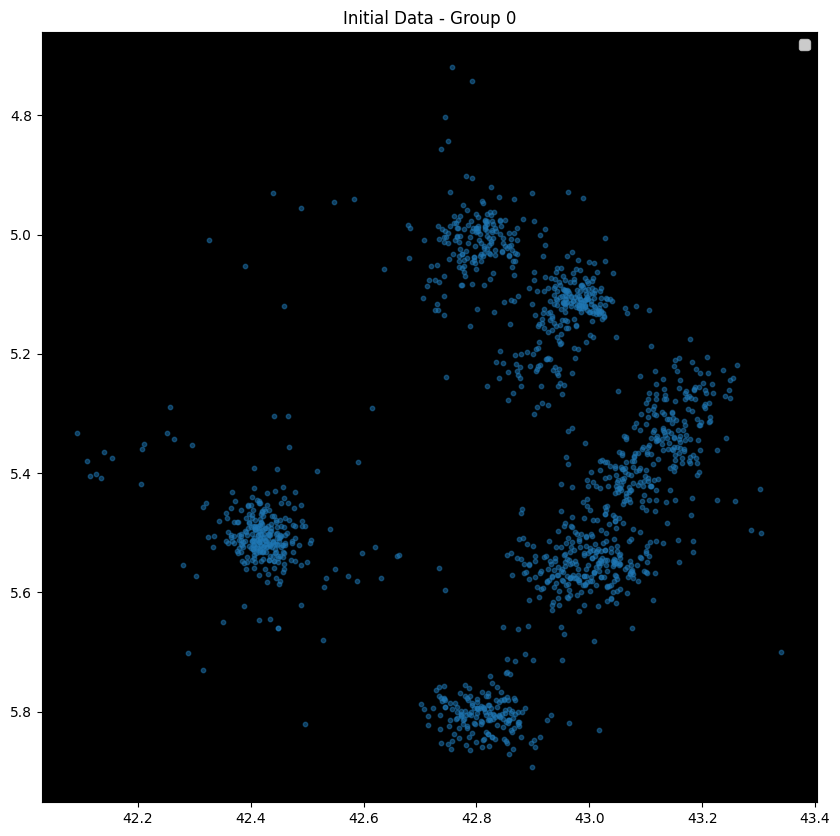

K-Means labels:
 [4 4 4 ... 1 4 5]


/tmp/ipykernel_3018/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


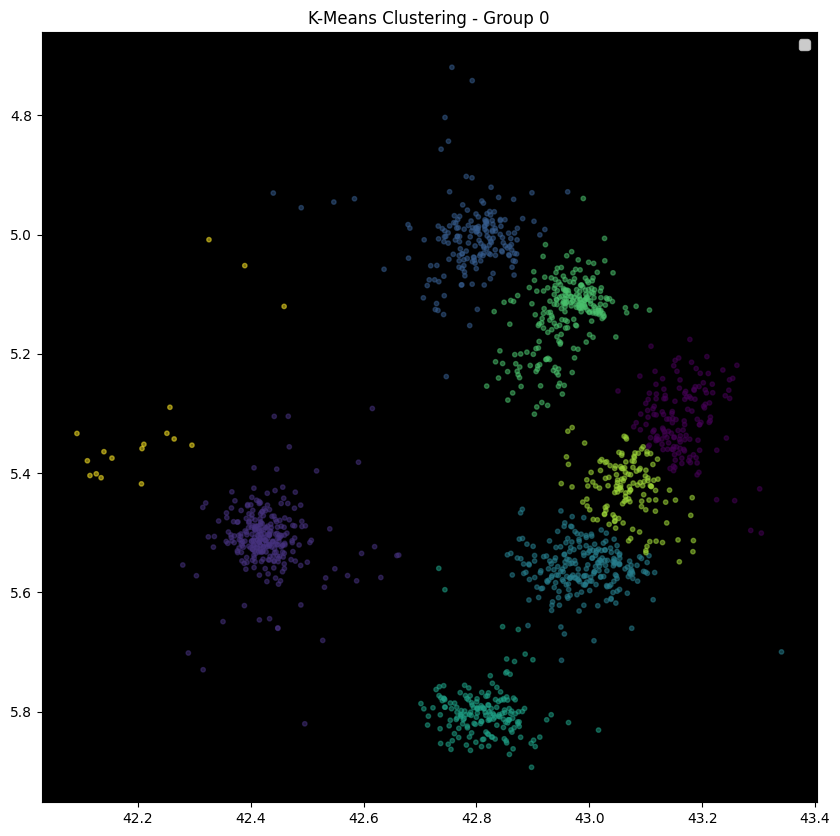

Centers of Mass (COM):
 [(np.float64(43.16317016399459), np.float64(5.311793418909541)), (np.float64(42.428676454824355), np.float64(5.510897815868419)), (np.float64(42.7921301559363), np.float64(5.007392254621623)), (np.float64(42.99031712458684), np.float64(5.559659788751195)), (np.float64(42.81480174953655), np.float64(5.800401194620941)), (np.float64(42.959169372310484), np.float64(5.132997377132012)), (np.float64(43.06668437119071), np.float64(5.425975058941131)), (np.float64(42.21997384464039), np.float64(5.311504700604607))]


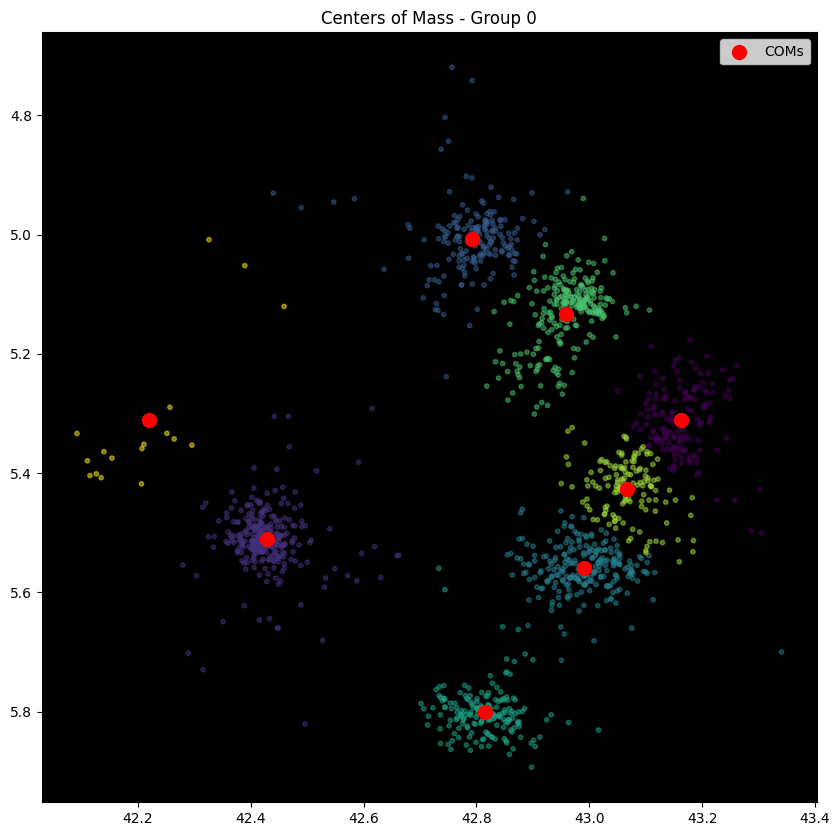

Minimum Bounding Rectangle:
 [[43.18725417  5.30364256]
 [42.57182881  4.84221794]
 [42.19937639  5.33897657]
 [42.81480175  5.80040119]]
Closest side of bounding rectangle:
 3
Rotation angle:
 4.069038044581268
Rotated Data:
 [[42.83957494  5.67830498]
 [42.84068409  5.77847519]
 [42.81540375  5.78075162]
 [42.79189394  5.7415125 ]
 [42.81996776  5.76986802]]
Rotated Centers of Mass (COM):
 [[42.21489231  5.81478104]
 [42.81480175  6.28300346]
 [42.19392338  6.2942506 ]
 [42.5168988   5.804389  ]
 [42.81480175  5.80040119]
 [42.19421534  6.08525619]
 [42.3641278   5.8234831 ]
 [42.78046578  6.56959627]]


/tmp/ipykernel_3018/2632525597.py:89: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


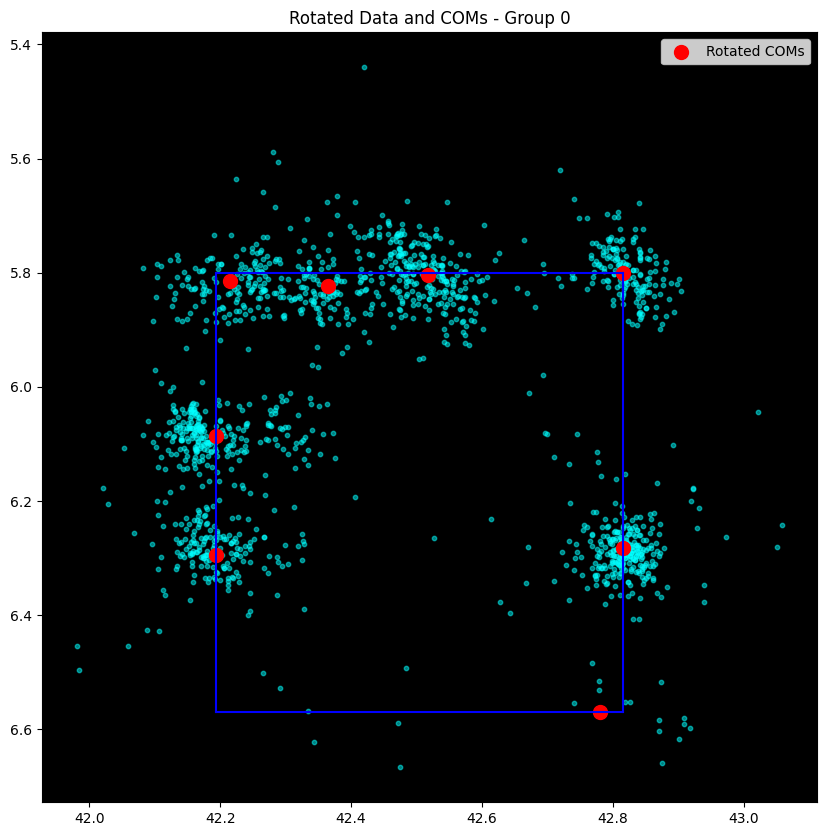

Second Highest COM:
 [42.19421534  6.08525619]
Right Most COM:
 [42.81480175  5.80040119]
Second Right Most COM:
 [42.81480175  6.28300346]
Robot COM:
 [42.5168988  5.804389 ]


/tmp/ipykernel_3018/1578615086.py:125: RuntimeWarning: divide by zero encountered in scalar divide
  m = (y2-y1) / (x2-x1)
/tmp/ipykernel_3018/1578615086.py:127: RuntimeWarning: invalid value encountered in scalar divide
  x = (m*y0 + x0 - m*c) / (m**2 + 1)
/tmp/ipykernel_3018/1578615086.py:127: RuntimeWarning: invalid value encountered in scalar subtract
  x = (m*y0 + x0 - m*c) / (m**2 + 1)


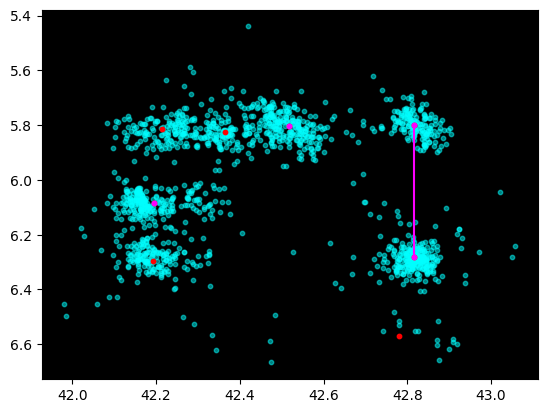

Ratio:
 0.48003460291608396

Processing Group 1
Data collected:
            x         y
0  74.181908  2.675268
1  74.218697  2.590031
2  74.369797  3.188938
3  74.364662  3.175110
4  74.386177  3.169834


/tmp/ipykernel_3018/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


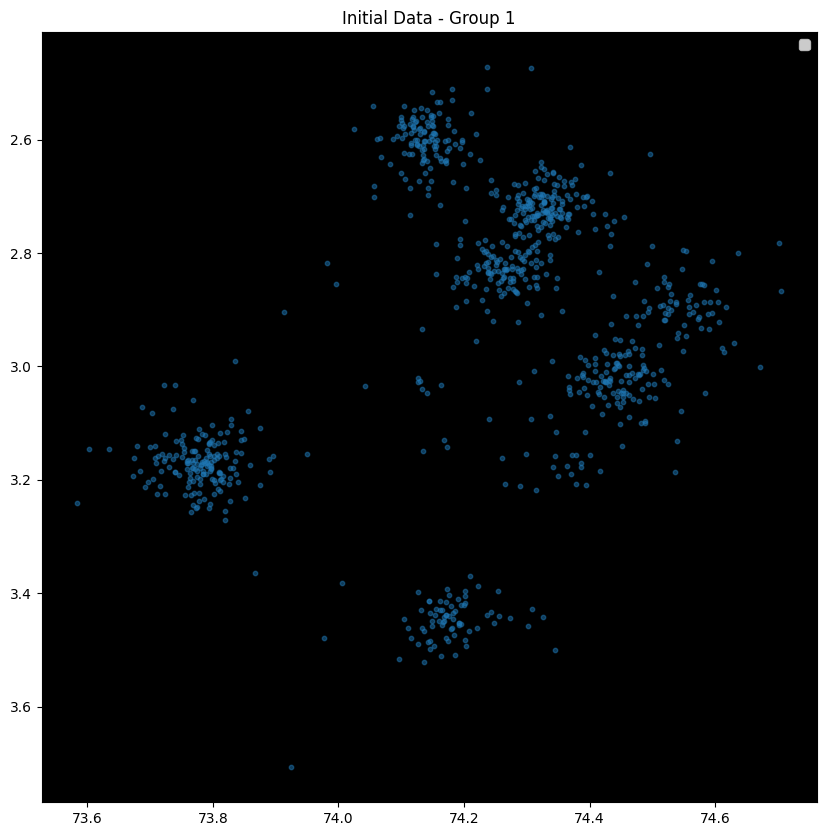

K-Means labels:
 [4 4 6 6 6 6 6 6 6 6 6 3 6 1 1 0 7 7 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 3 3 3 1 1 1 2 2 2 3 3 3 3 3 3 3 2 2 1 1 1 1 1 1 1 4 4 5 5 4 4 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 7 7 7 7 3 3 7 7 3 3 5 5 5 5 5 5 5 5 0 0 0 7 0 2 2 2 2 3 3 3 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 6 6 6 6 6 2 2 2 2 2 2 2 2 3 3 3 3 2
 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 5 5 5 5 5 5
 5 5 4 4 4 4 4 4 4 3 3 3 3 3 3 3 4 4 4 4 5 5 5 7 5 0 3 2 2 2 2 2 2 2 2 4 4
 0 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 5 5 2 5 5 2 4 4 0 0 0 0 0 0 5 0 0 0 0 0 0
 0 0 0 0 5 5 5 5 5 5 5 5 5 5 5 5 0 0 0 0 0 0 0 0 0 6 6 6 6 1 0 4 4 4 3 3 3
 3 6 3 3 3 3 4 5 0 0 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 6 5 4 4
 4 4 4 1 1 1 1 1 1 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 5 0 5 5 0 4 0 7 1 1
 1 1 1 1 1 4 4 4 4 1 1 1 1 1 1 1 4 4 4 4 4 4 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 3 3 6 6 6 5 0 0 4 4 4 4 4 6 1 1 1 1 1 5 5 0 0 0 0 0 0 0 0 0 0
 4 4 5 5

/tmp/ipykernel_3018/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


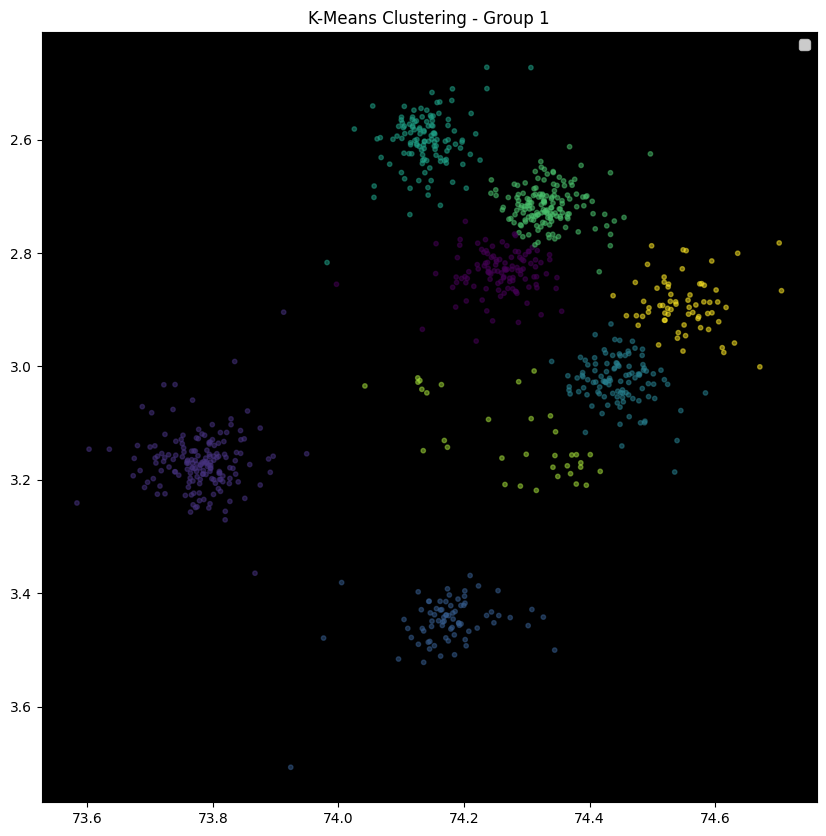

Centers of Mass (COM):
 [(np.float64(74.25769353545873), np.float64(2.8338319559012892)), (np.float64(73.77946074708493), np.float64(3.168646534046013)), (np.float64(74.17461903889973), np.float64(3.4499339803059894)), (np.float64(74.44544079981813), np.float64(3.026104297112981)), (np.float64(74.13930593443311), np.float64(2.602285968370674)), (np.float64(74.33297290677339), np.float64(2.717069082010805)), (np.float64(74.27897172815659), np.float64(3.127372938043931)), (np.float64(74.55210321599787), np.float64(2.89046692125725))]


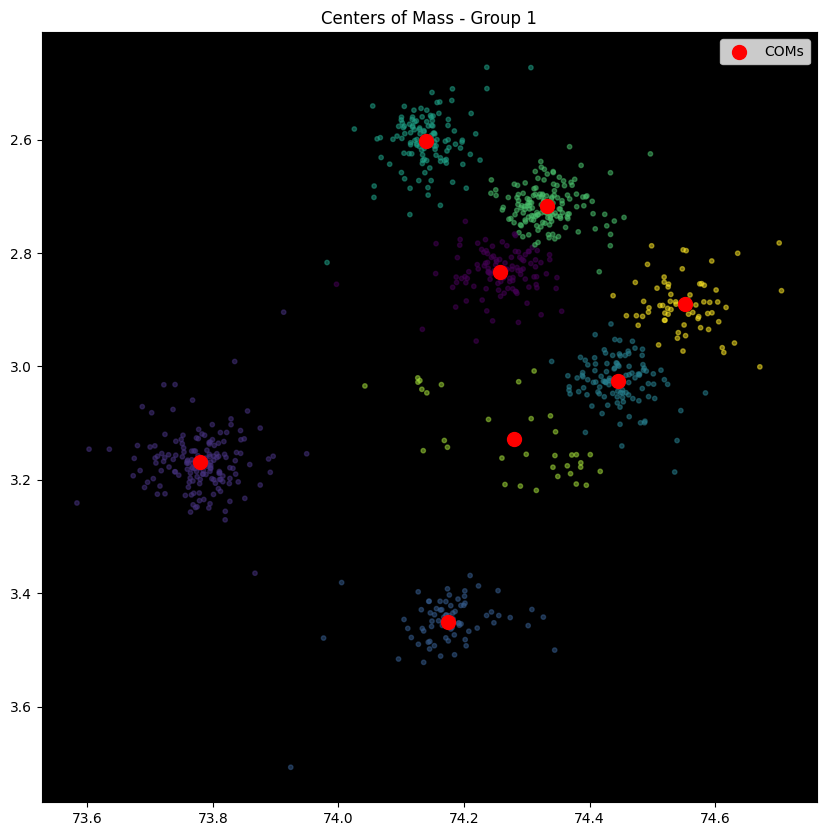

Minimum Bounding Rectangle:
 [[74.56394754  2.87291252]
 [74.14667238  2.5913682 ]
 [73.75734388  3.16838966]
 [74.17461904  3.44993398]]
Closest side of bounding rectangle:
 3
Rotation angle:
 4.118831004357363
Rotated Data:
 [[73.52837842  3.87717358]
 [73.43714392  3.89435156]
 [73.84909918  3.43411901]
 [73.84050839  3.44610944]
 [73.82410087  3.43122573]]
Rotated Centers of Mass (COM):
 [[73.6174329   3.72566335]
 [74.1624617   3.93483078]
 [74.17461904  3.44993398]
 [73.67180853  3.46248854]
 [73.49170733  3.95330835]
 [73.47853682  3.72856718]
 [73.84886424  3.5438431 ]
 [73.49971335  3.44993398]]


/tmp/ipykernel_3018/2632525597.py:89: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


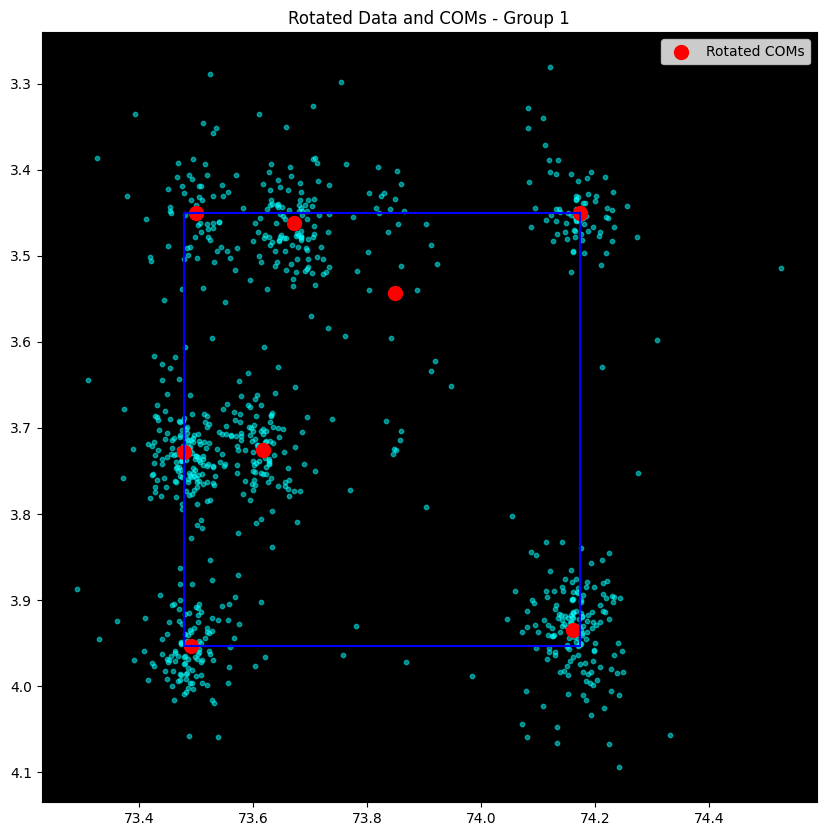

Second Highest COM:
 [73.47853682  3.72856718]
Right Most COM:
 [74.17461904  3.44993398]
Second Right Most COM:
 [74.1624617   3.93483078]
Robot COM:
 [73.6174329   3.72566335]


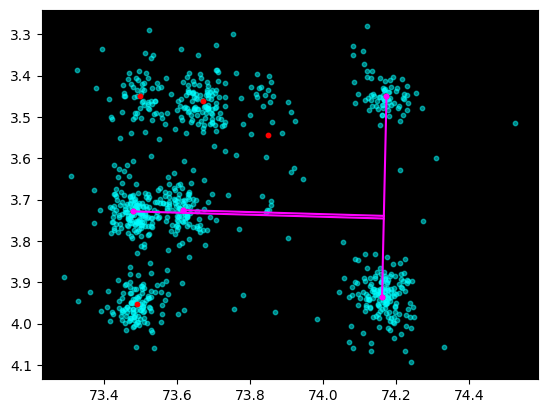

Ratio:
 0.798543006674123

Processing Group 2
Data collected:
            x          y
0  80.229553  11.981121
1  80.168312  11.962978
2  80.124626  11.972430
3  80.120476  11.994550
4  80.130730  11.978308


/tmp/ipykernel_3018/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


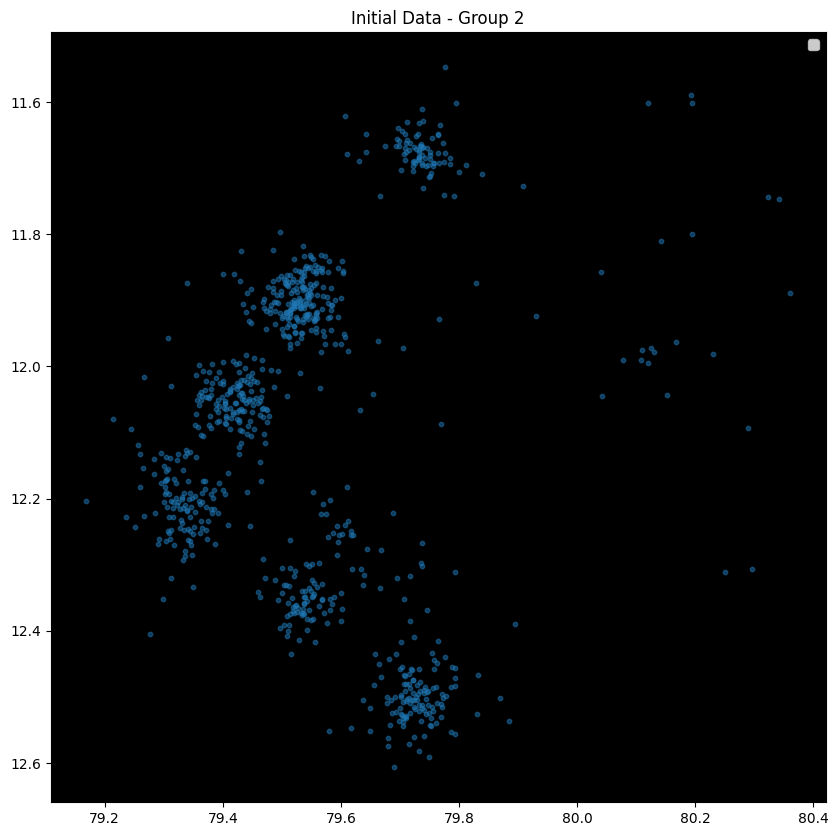

K-Means labels:
 [3 3 3 3 3 5 5 0 0 7 7 7 7 7 7 7 7 7 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 2 2 2 2 1 1
 1 1 1 1 1 1 1 1 1 7 1 3 7 5 5 5 2 2 7 7 7 0 7 0 7 0 7 7 7 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 7 0 0 0 7 0 7 6 5 5 5 6 6 6 6 6 7 7 0 7 7 0
 7 7 7 7 7 7 7 7 7 0 7 0 7 3 3 2 2 2 0 1 1 1 1 1 1 1 1 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 5 3 3 1 4 4
 4 4 4 5 1 1 1 1 1 1 1 1 1 1 6 6 6 6 6 6 6 6 6 6 6 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 0 2 2 2 2 2 2 2 6 6 6 6 5 1 1 1 1 1 2 6 6 4 4 4 4 4 4 4 4 6 6 2 2 6
 1 1 1 1 1 1 6 0 0 4 4 6 6 6 6 2 2 2 1 1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 5 2 2 4 4 4 4 4 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 4 4 6 7
 4 0 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 5 1 1 1 1 1 1 1 3 3 4 1 1 1 7 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 3 6 5 5 5 5 5 5 5 5 5 5 5 7 7 7 2 2 5 2
 2 2 7 7 7 7 7 7 7 0 7 4 4 6 6 7 7 7 7 6 3 3 6 6 6 7 7 7 7 2 2 2 2 7 2 2 4
 4 4 4 4

/tmp/ipykernel_3018/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


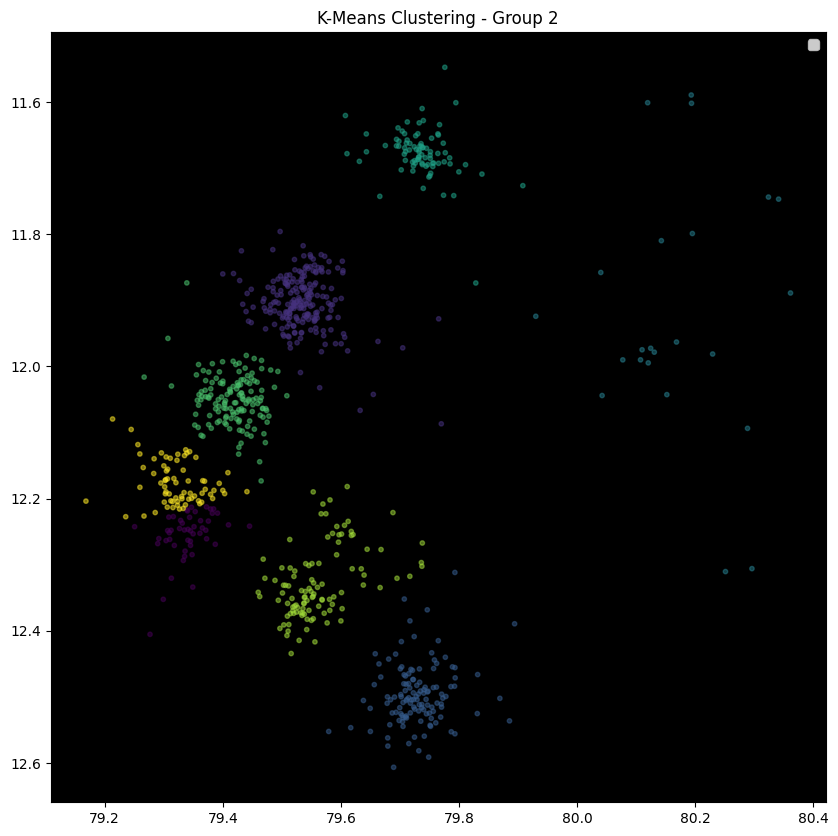

Centers of Mass (COM):
 [(np.float64(79.34141493816765), np.float64(12.25479135707933)), (np.float64(79.5342530664408), np.float64(11.903688759173987)), (np.float64(79.72952196674962), np.float64(12.496960755317442)), (np.float64(80.17131506878397), np.float64(11.921803806139076)), (np.float64(79.73547944568452), np.float64(11.677294004531134)), (np.float64(79.41719585445756), np.float64(12.050053156859486)), (np.float64(79.56182626029042), np.float64(12.327570995437764)), (np.float64(79.32252284458706), np.float64(12.176629556928361))]


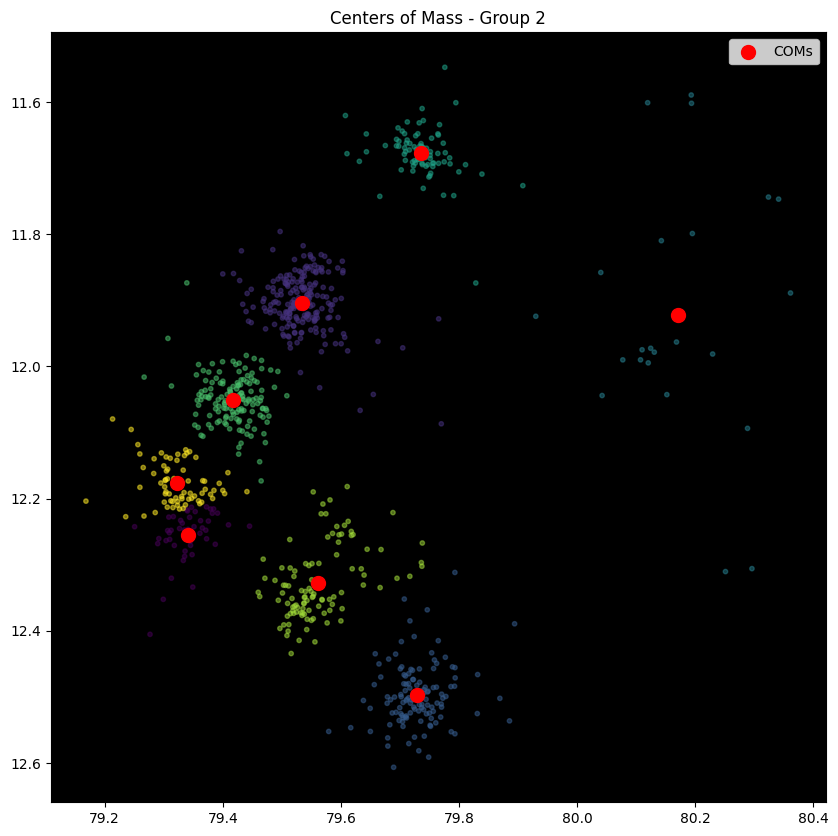

Minimum Bounding Rectangle:
 [[80.17131507 11.92180381]
 [79.75898791 11.60508452]
 [79.29016781 12.21542709]
 [79.70249497 12.53214638]]
Closest side of bounding rectangle:
 1
Rotation angle:
 0.9157950413600795
Rotated Data:
 [[79.74742289 12.20733152]
 [79.72450523 12.14771259]
 [79.69039774 12.1188253 ]
 [79.67032766 12.12900818]
 [79.68945463 12.12724602]]
Rotated Centers of Mass (COM):
 [[78.9893709  11.66970506]
 [79.38528113 11.60875704]
 [79.03373853 12.1250122 ]
 [79.75898791 12.1250122 ]
 [79.68740196 11.63042835]
 [79.19790066 11.60508452]
 [79.06591903 11.88883609]
 [79.03984858 11.60710968]]


/tmp/ipykernel_3018/2632525597.py:89: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


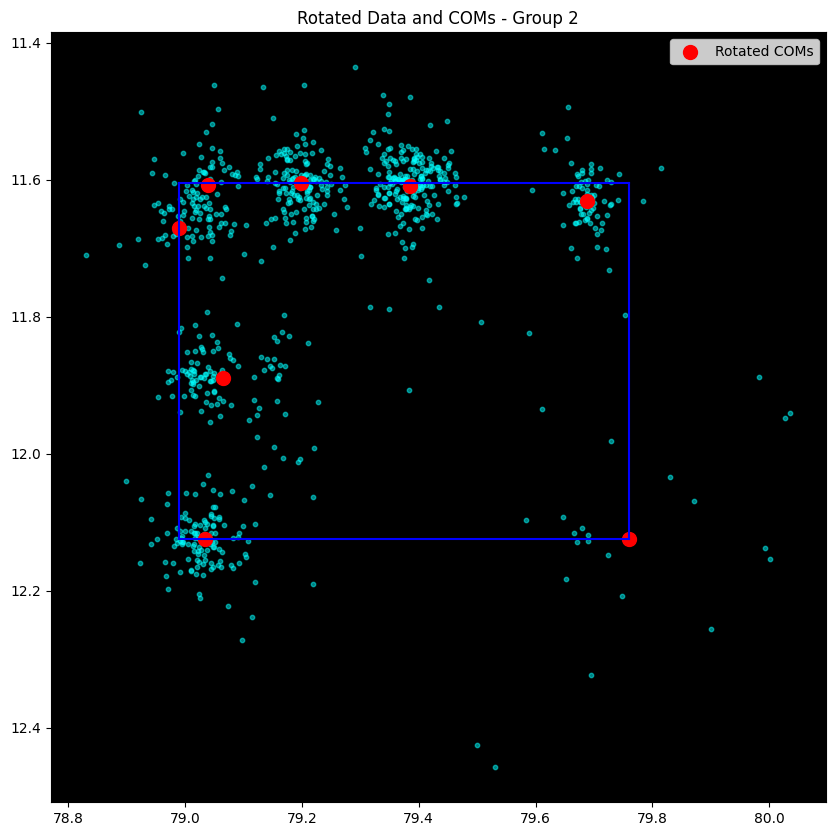

Second Highest COM:
 [78.9893709  11.66970506]
Right Most COM:
 [79.75898791 12.1250122 ]
Second Right Most COM:
 [79.68740196 11.63042835]
Robot COM:
 [79.19790066 11.60508452]


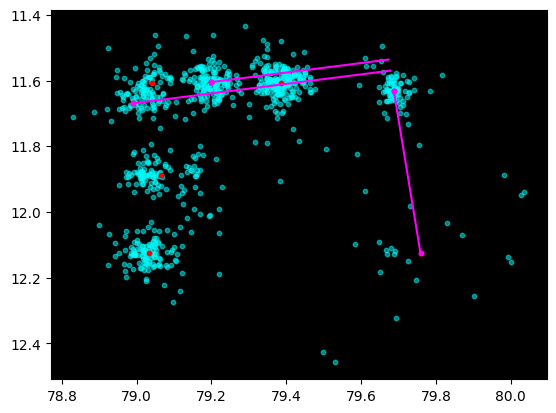

Ratio:
 0.6903822867039773

Processing Group 3
Data collected:
            x         y
0  96.276115  5.262790
1  96.280777  5.182926
2  96.253075  5.196754
3  96.216118  5.205290
4  96.236908  5.174649


/tmp/ipykernel_3018/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


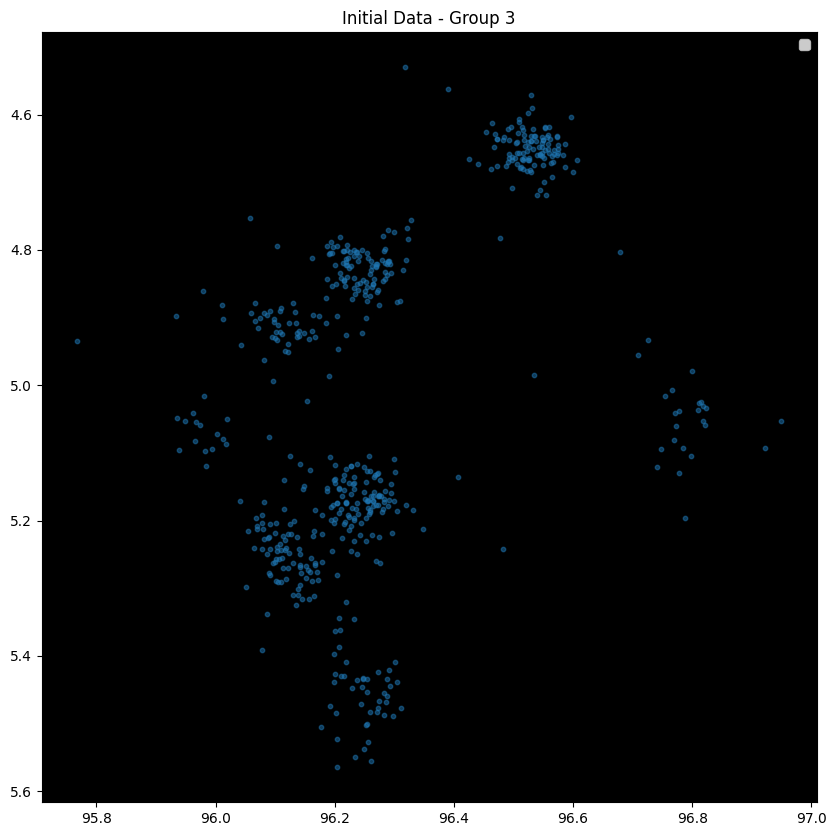

K-Means labels:
 [5 5 5 5 5 2 2 2 2 2 2 2 2 4 4 4 4 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 0
 0 0 0 0 0 6 6 6 1 1 1 0 0 0 0 4 4 4 4 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 5 5 0 0 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 6 2 2 2 2 2 2 2
 0 0 2 2 2 2 2 0 0 0 0 5 5 5 5 2 2 2 2 2 2 2 2 2 2 2 2 2 5 5 5 5 5 5 5 4 4
 4 4 4 5 1 1 1 7 7 7 7 5 7 5 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5
 5 5 1 5 1 1 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 5 1 1 4 4
 4 4 4 6 6 1 5 5 4 1 1 1 5 5 6 6 6 6 1 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 5
 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 2 2 2 2 2 7 7 7 4 4 4 4 4 1 3 3 3 3 3 3 3
 3 3 3 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 0 0 0 0 0 0 0 0 5 5 5 5 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 1 1
 5 1 1 5 5 5 5 7 7 7 1 1 1 5 5 7 5 5 5 3 2 2 2 2 2 2 2 5 3 3 2 2 5 5 6 5 5
 5 5 3 3 3 5 5 5 5 3 3 3 7 5 5 5 5 5 5 5 5 5 5 5 5 5 2 5 5 5 5 5 5 5 5 5 5
 5 3 1 1

/tmp/ipykernel_3018/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


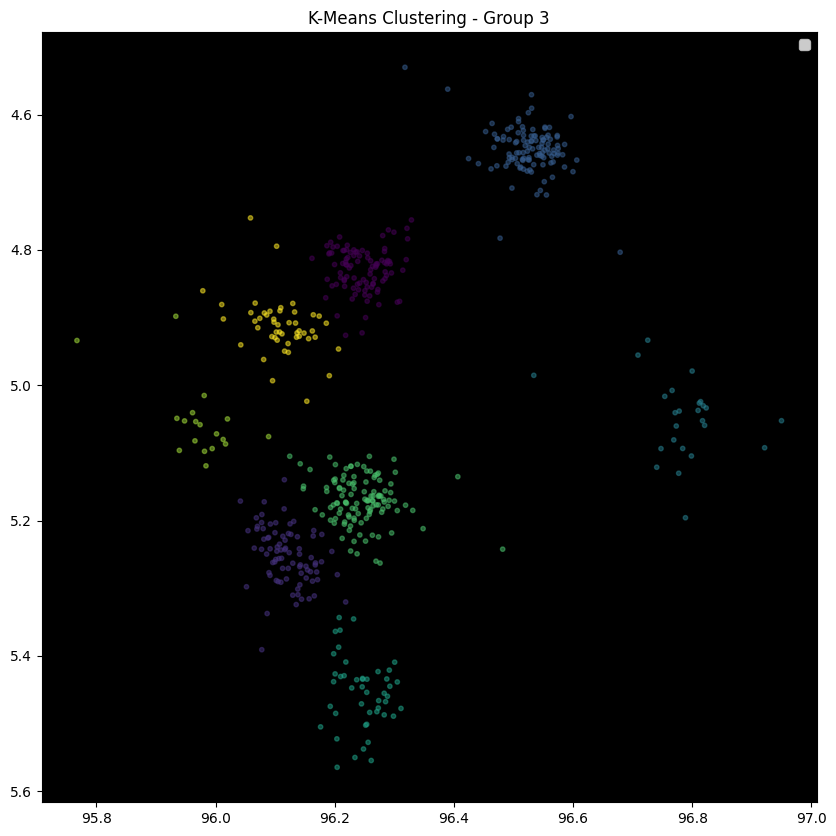

Centers of Mass (COM):
 [(np.float64(96.2470948961046), np.float64(4.829189396867848)), (np.float64(96.12027545091583), np.float64(5.252703178219679)), (np.float64(96.52659242343059), np.float64(4.651792268837448)), (np.float64(96.78432647705078), np.float64(5.049751472473145)), (np.float64(96.24598710433297), np.float64(5.454964492631995)), (np.float64(96.24395824300832), np.float64(5.169995365471675)), (np.float64(95.97059546576605), np.float64(5.053029855092366)), (np.float64(96.10949961344402), np.float64(4.912443409363429))]


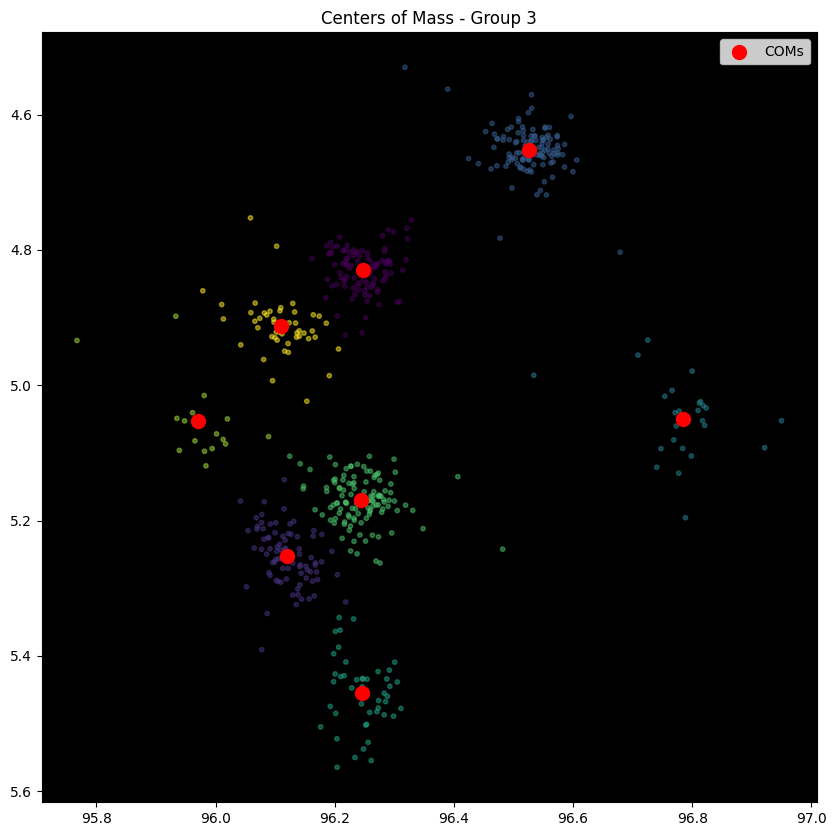

Minimum Bounding Rectangle:
 [[96.81144371  5.06753329]
 [96.51487669  4.63469313]
 [95.94942008  5.02212434]
 [96.2459871   5.45496449]]
Closest side of bounding rectangle:
 2
Rotation angle:
 2.1714965305334952
Rotated Data:
 [[95.56623036  5.15559919]
 [95.62947897  5.20458573]
 [95.633729    5.17391667]
 [95.64757615  5.1386049 ]
 [95.66110261  5.17307471]]
Rotated Centers of Mass (COM):
 [[95.94032801  5.37673895]
 [95.66263545  5.03274195]
 [95.92869235  5.7075761 ]
 [95.45472336  5.69525665]
 [95.42472722  5.02212434]
 [95.66095642  5.18152097]
 [95.91195613  5.02212434]
 [95.94942008  5.21617424]]


/tmp/ipykernel_3018/2632525597.py:89: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


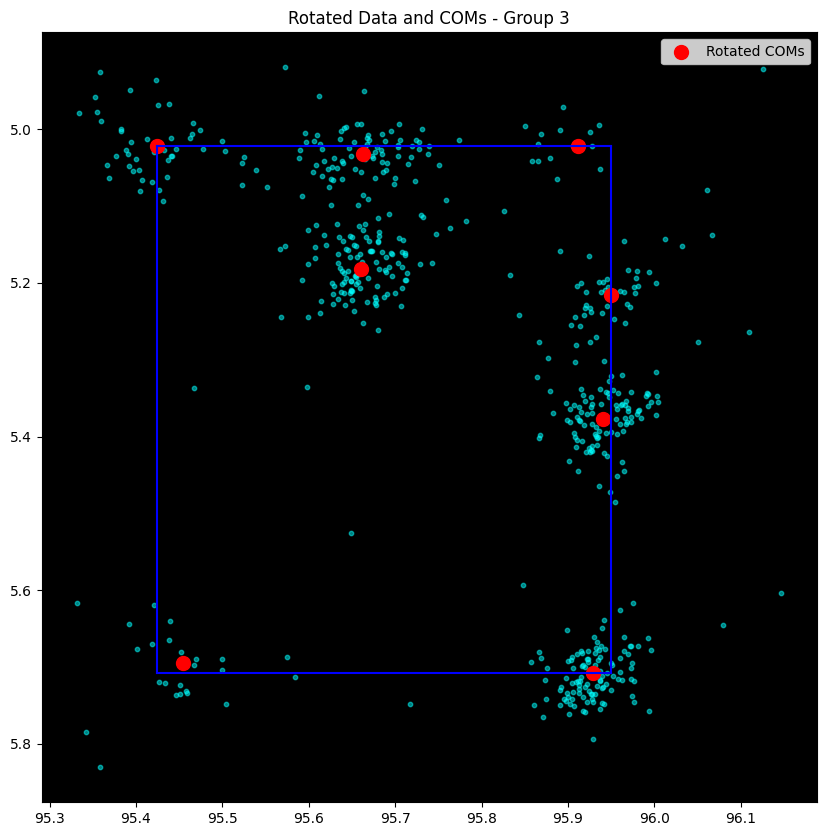

Second Highest COM:
 [95.66095642  5.18152097]
Right Most COM:
 [95.94942008  5.21617424]
Second Right Most COM:
 [95.94032801  5.37673895]
Robot COM:
 [95.66095642  5.18152097]


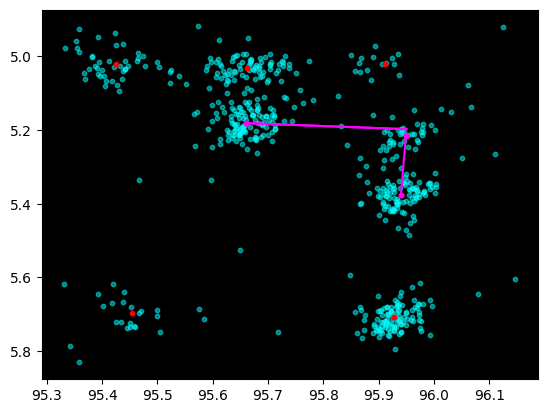

Ratio:
 1.0

Processing Group 4
Data collected:
             x          y
0  154.937286  12.149701
1  154.065964  12.067630
2  154.442245  12.426337
3  154.473663  12.418509
4  154.446823  12.387403


/tmp/ipykernel_3018/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


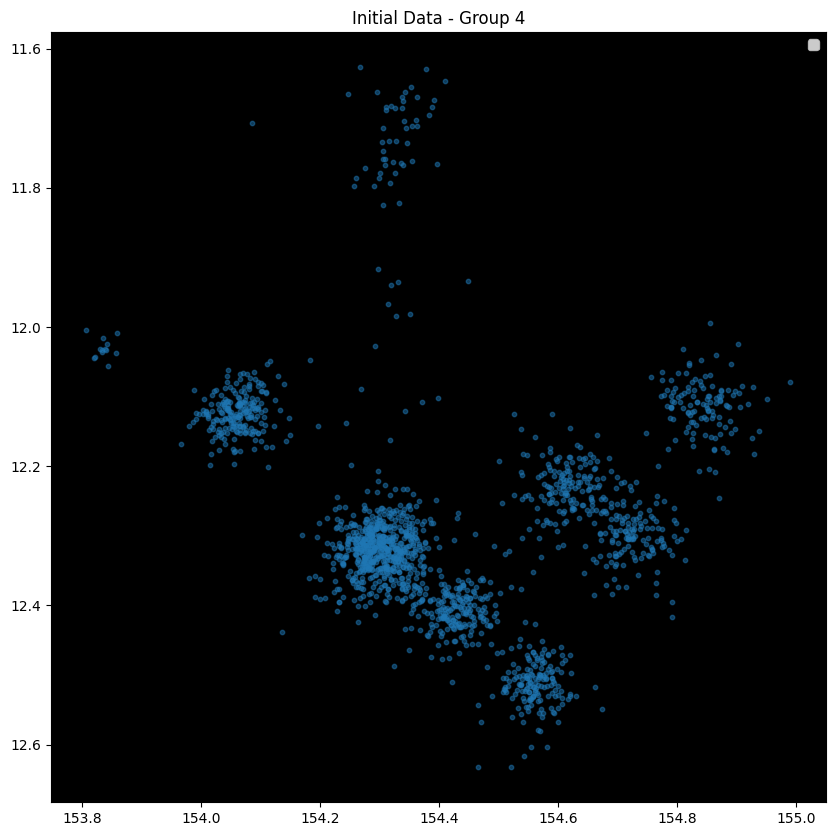

K-Means labels:
 [6 2 3 ... 7 1 7]


/tmp/ipykernel_3018/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


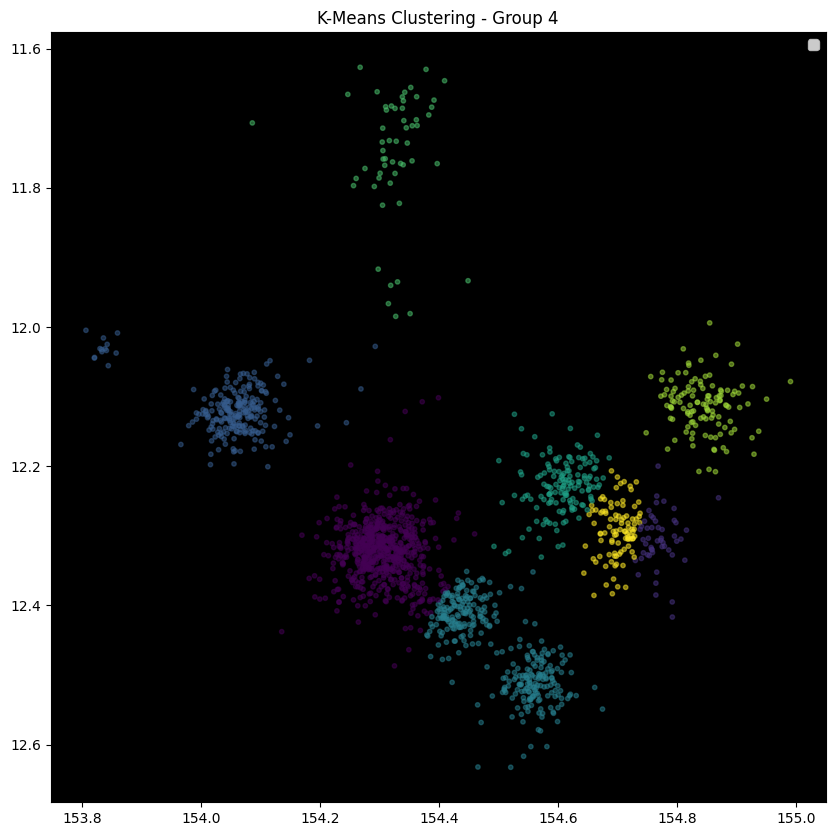

Centers of Mass (COM):
 [(np.float64(154.3042445484038), np.float64(12.322543001689235)), (np.float64(154.76989318847657), np.float64(12.305460529327393)), (np.float64(154.0520172776847), np.float64(12.117723403305844)), (np.float64(154.49933467124825), np.float64(12.461682202922765)), (np.float64(154.6052888623711), np.float64(12.228826957495034)), (np.float64(154.32502330433238), np.float64(11.752556471391157)), (np.float64(154.8439743041992), np.float64(12.112519478797912)), (np.float64(154.69947690379863), np.float64(12.292428814634984))]


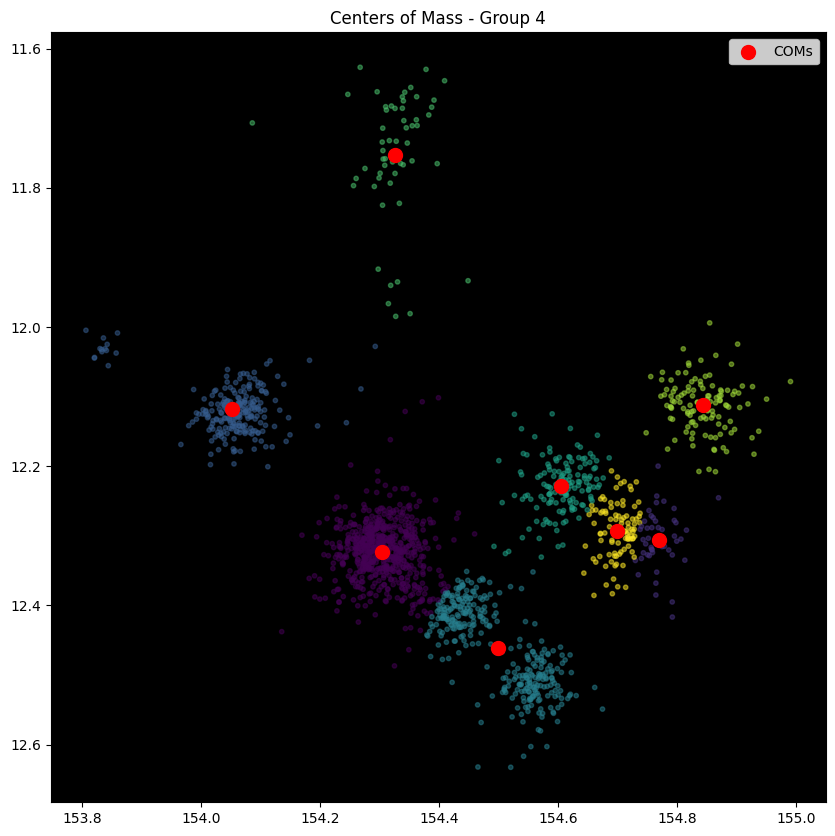

Minimum Bounding Rectangle:
 [[154.88608142  12.14255047]
 [154.32149407  11.73988409]
 [154.04023191  12.13424793]
 [154.60481925  12.53691431]]
Closest side of bounding rectangle:
 3
Rotation angle:
 4.092855637658642
Rotated Data:
 [[154.09652103  12.49107375]
 [154.53564082  13.24811579]
 [154.60919231  12.73348082]
 [154.58457563  12.71244778]
 [154.57483561  12.75236159]]
Rotated Centers of Mass (COM):
 [[154.60481925  12.90610289]
 [154.32053022  12.53691431]
 [154.58452258  13.23038319]
 [154.60481925  12.66647845]
 [154.35371741  12.71542453]
 [154.1286997   13.22015158]
 [154.12043177  12.58863345]
 [154.35080804  12.60181063]]


/tmp/ipykernel_3018/2632525597.py:89: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


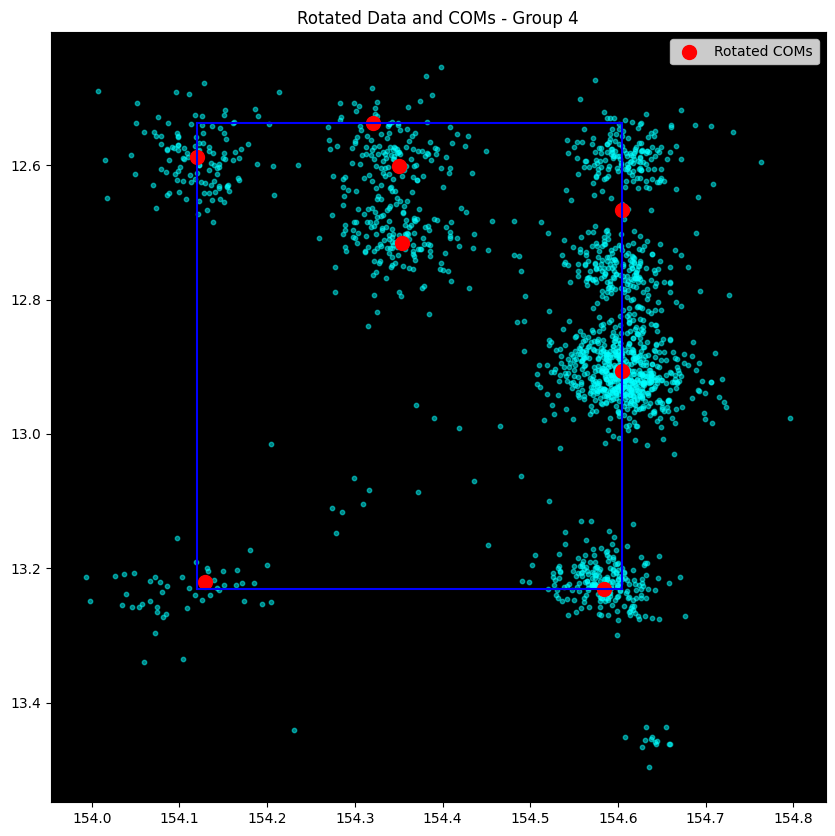

Second Highest COM:
 [154.12043177  12.58863345]
Right Most COM:
 [154.60481925  12.90610289]
Second Right Most COM:
 [154.60481925  12.66647845]
Robot COM:
 [154.35371741  12.71542453]


/tmp/ipykernel_3018/1578615086.py:125: RuntimeWarning: divide by zero encountered in scalar divide
  m = (y2-y1) / (x2-x1)
/tmp/ipykernel_3018/1578615086.py:127: RuntimeWarning: invalid value encountered in scalar subtract
  x = (m*y0 + x0 - m*c) / (m**2 + 1)
/tmp/ipykernel_3018/1578615086.py:127: RuntimeWarning: invalid value encountered in scalar divide
  x = (m*y0 + x0 - m*c) / (m**2 + 1)


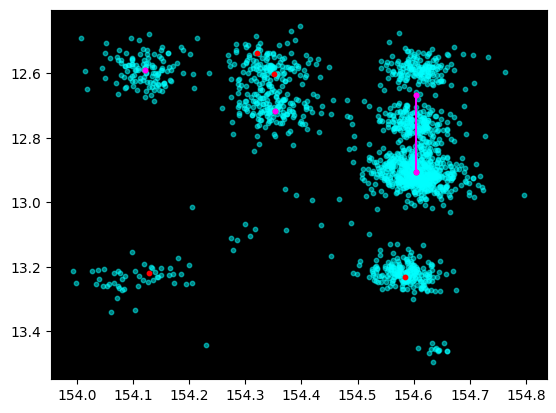

Ratio:
 0.5183904459835983

Processing Group 5
Data collected:
             x          y
0  190.320480  16.102219
1  190.276398  16.173414
2  190.258575  16.114859
3  190.139954  16.050495
4  190.059372  16.388666


/tmp/ipykernel_3018/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


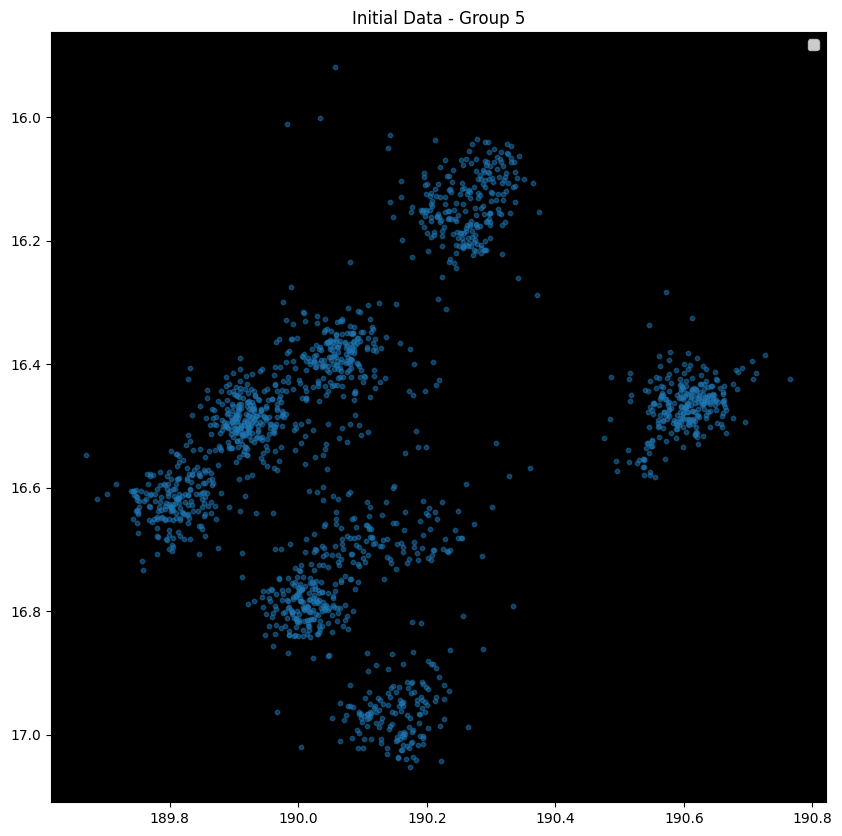

K-Means labels:
 [3 3 3 ... 5 5 5]


/tmp/ipykernel_3018/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


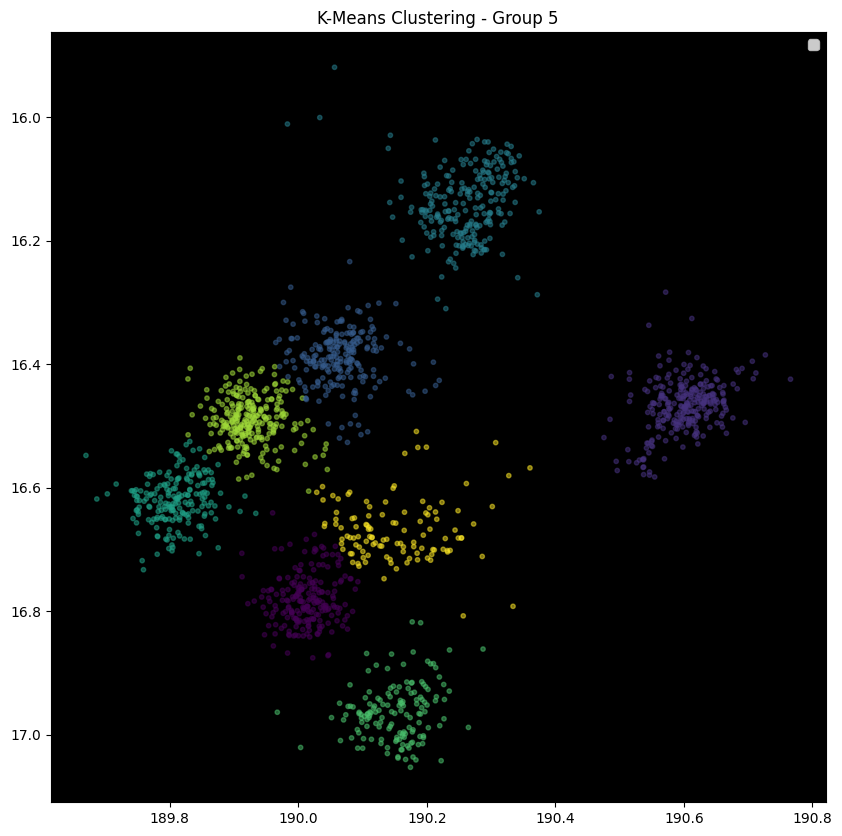

Centers of Mass (COM):
 [(np.float64(190.01244960321444), np.float64(16.78110601300391)), (np.float64(190.60105555651356), np.float64(16.46740259645597)), (np.float64(190.06448176990855), np.float64(16.389071169766513)), (np.float64(190.25993032823817), np.float64(16.14046060783157)), (np.float64(189.80871913408993), np.float64(16.619934216894286)), (np.float64(190.1514623245137), np.float64(16.963087056307184)), (np.float64(189.92585914411794), np.float64(16.49013715022512)), (np.float64(190.15218339886582), np.float64(16.667653251112554))]


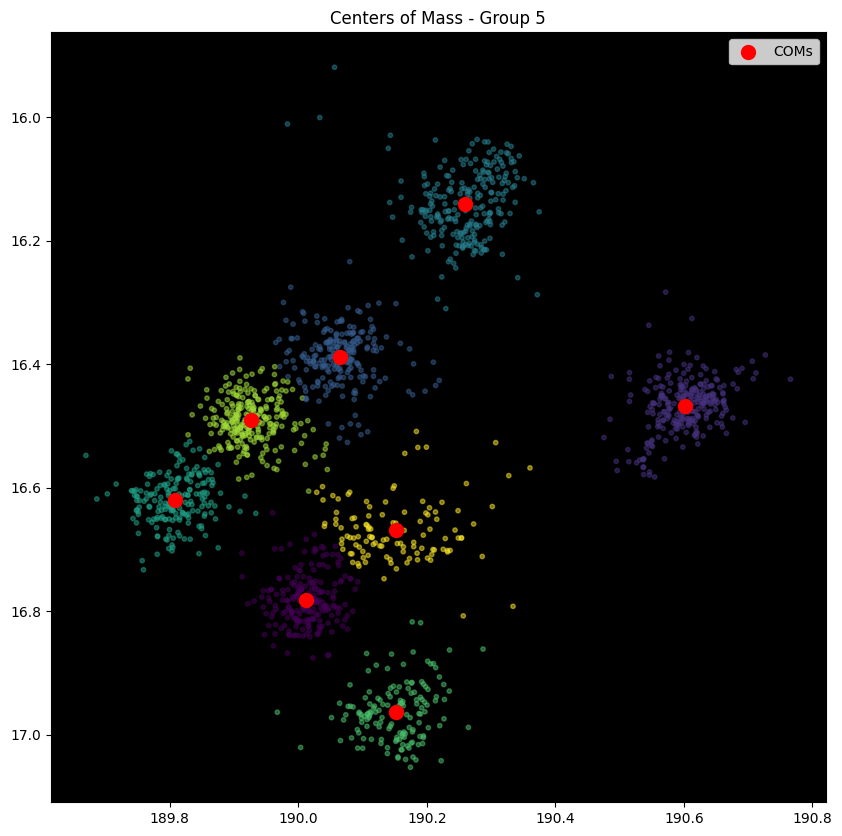

Minimum Bounding Rectangle:
 [[190.61410696  16.47883105]
 [190.25993033  16.14046061]
 [189.79728569  16.62471661]
 [190.15146232  16.96308706]]
Closest side of bounding rectangle:
 1
Rotation angle:
 0.8082174707181253
Rotated Data:
 [[190.32940871  16.1578246 ]
 [190.24747845  16.17513144]
 [190.27750608  16.12179539]
 [190.24210196  15.99156351]
 [189.94192018  16.16690298]]
Rotated Centers of Mass (COM):
 [[189.62575039  16.40406836]
 [190.25917799  16.61296132]
 [189.94515713  16.17087746]
 [190.25993033  16.14046061]
 [189.60155213  16.14542401]
 [189.5901961   16.63029287]
 [189.77632177  16.14046061]
 [189.80430968  16.426732  ]]


/tmp/ipykernel_3018/2632525597.py:89: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


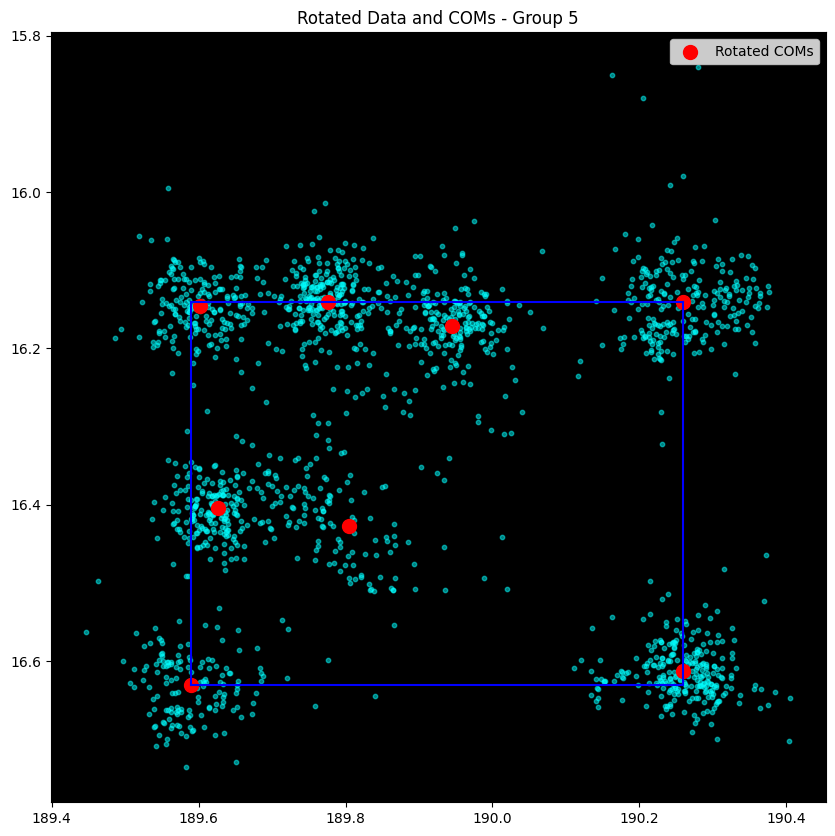

Second Highest COM:
 [189.62575039  16.40406836]
Right Most COM:
 [190.25993033  16.14046061]
Second Right Most COM:
 [190.25917799  16.61296132]
Robot COM:
 [189.80430968  16.426732  ]


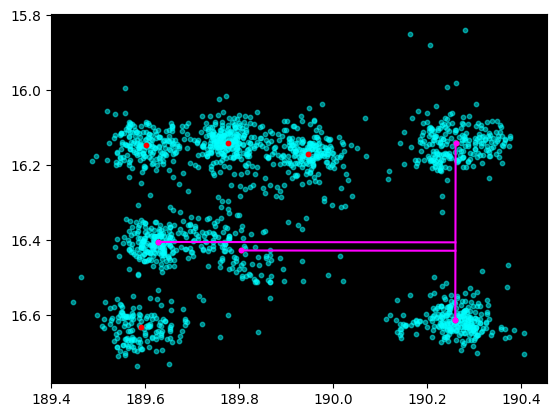

Ratio:
 0.7181972338647452

Processing Group 6
Data collected:
             x         y
0  192.853226  3.511629
1  192.808411  3.494667
2  192.990067  3.477808
3  192.797516  3.549601
4  192.846237  3.472739


/tmp/ipykernel_3018/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


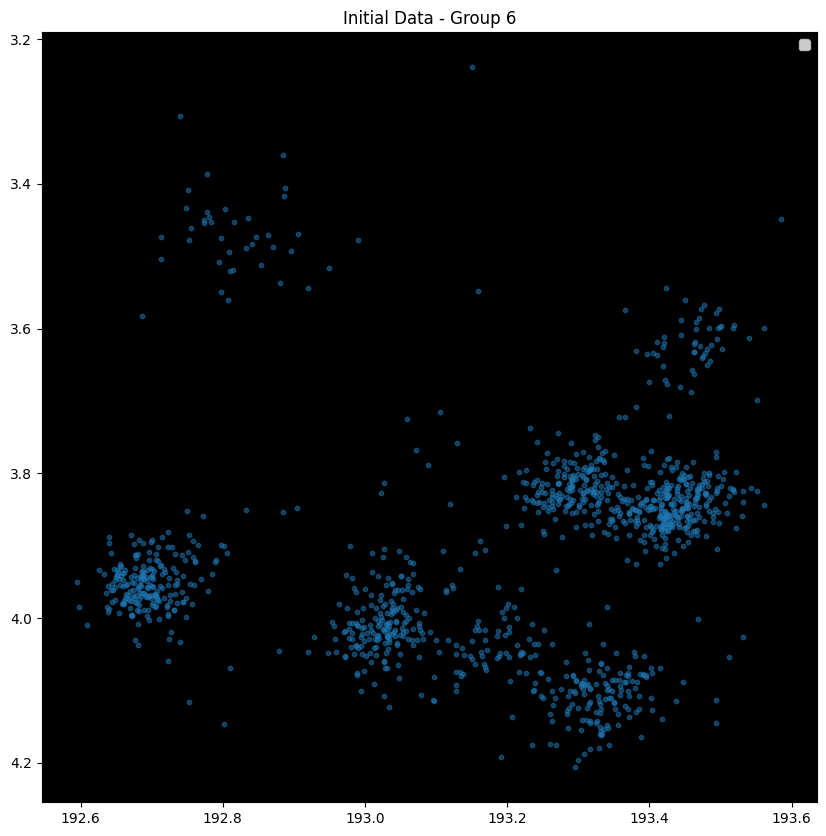

K-Means labels:
 [4 4 4 ... 1 1 1]


/tmp/ipykernel_3018/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


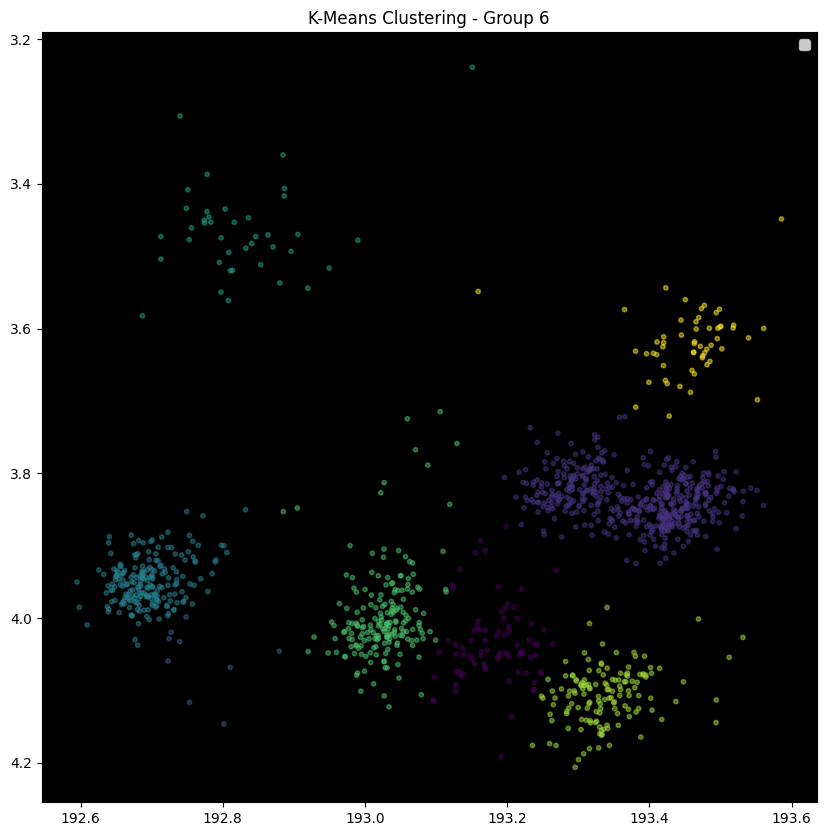

Centers of Mass (COM):
 [(np.float64(193.18226852416993), np.float64(4.034766006469726)), (np.float64(193.38031445575018), np.float64(3.8348252091356505)), (np.float64(192.7674560546875), np.float64(4.05716856320699)), (np.float64(192.6953262701267), np.float64(3.949697431703893)), (np.float64(192.82681579589843), np.float64(3.46524173617363)), (np.float64(193.02613160471438), np.float64(3.995522929247094)), (np.float64(193.33900570700354), np.float64(4.106393856359712)), (np.float64(193.4569785378196), np.float64(3.6193609411066228))]


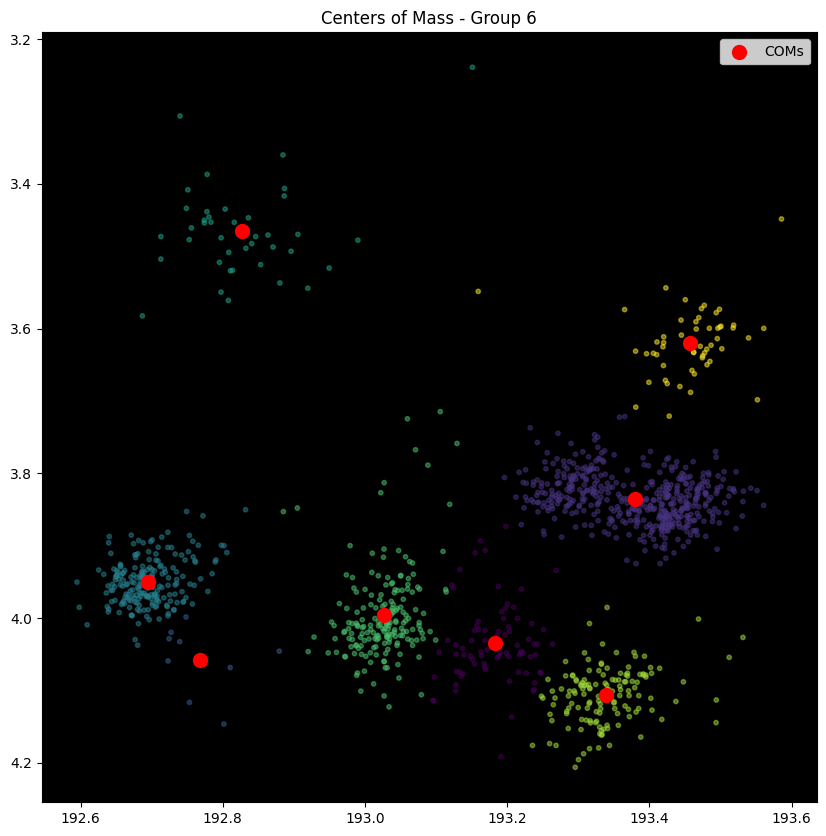

Minimum Bounding Rectangle:
 [[193.45731634   3.61796639]
 [192.81345855   3.46200624]
 [192.67473418   4.03470876]
 [193.31859196   4.19066891]]
Closest side of bounding rectangle:
 2
Rotation angle:
 2.903942429553453
Rotated Data:
 [[192.62440248   4.58510682]
 [192.67195121   4.59104203]
 [192.49936982   4.65019212]
 [192.66960724   4.53508714]
 [192.64035019   4.62125912]]
Rotated Centers of Mass (COM):
 [[192.18145119   4.15413663]
 [192.03604154   4.39508174]
 [192.57933088   4.03470876]
 [192.67473418   4.12217853]
 [192.66099066   4.62397324]
 [192.34243829   4.15551905]
 [192.0122567    4.12142096]
 [192.0122567    4.62253836]]


/tmp/ipykernel_3018/2632525597.py:89: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


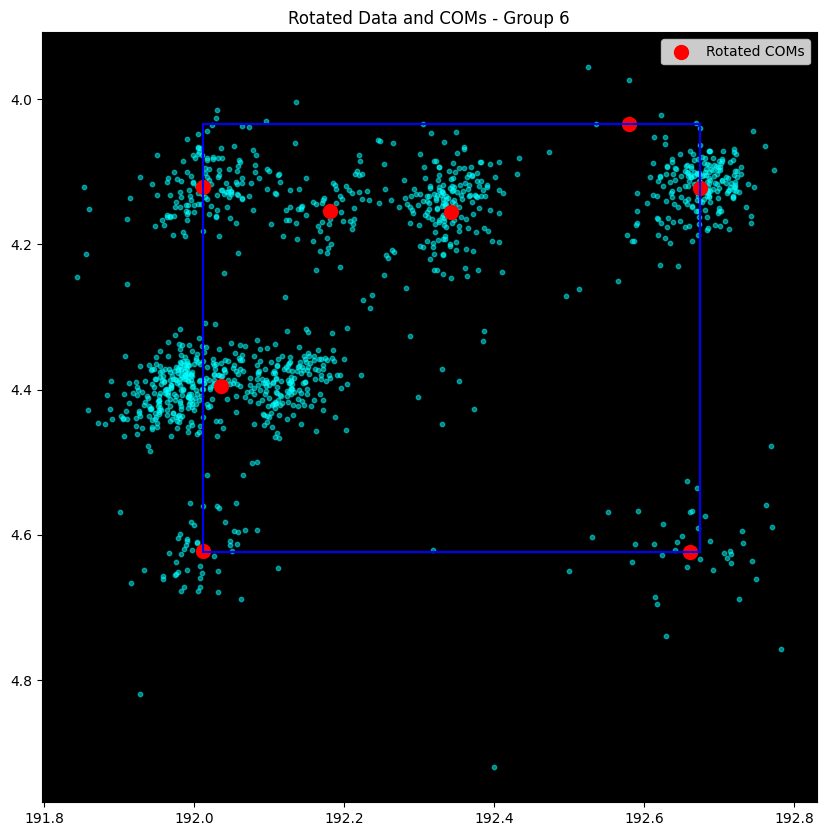

Second Highest COM:
 [192.03604154   4.39508174]
Right Most COM:
 [192.67473418   4.12217853]
Second Right Most COM:
 [192.66099066   4.62397324]
Robot COM:
 [192.34243829   4.15551905]


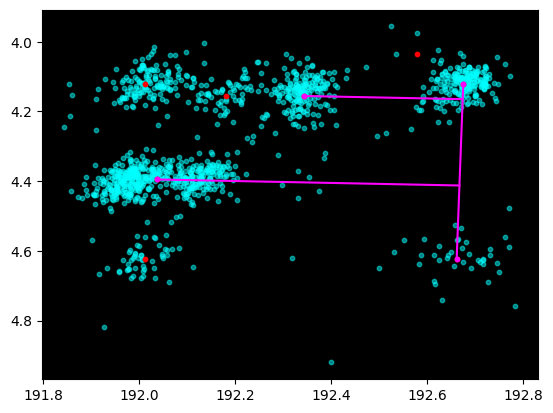

Ratio:
 0.5249892219327239

Processing Group 7
Data collected:
             x          y
0  223.384872  14.570362
1  223.379608  14.605626
2  223.415466  14.562952
3  223.395050  14.599780
4  223.444214  14.630434


/tmp/ipykernel_3018/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


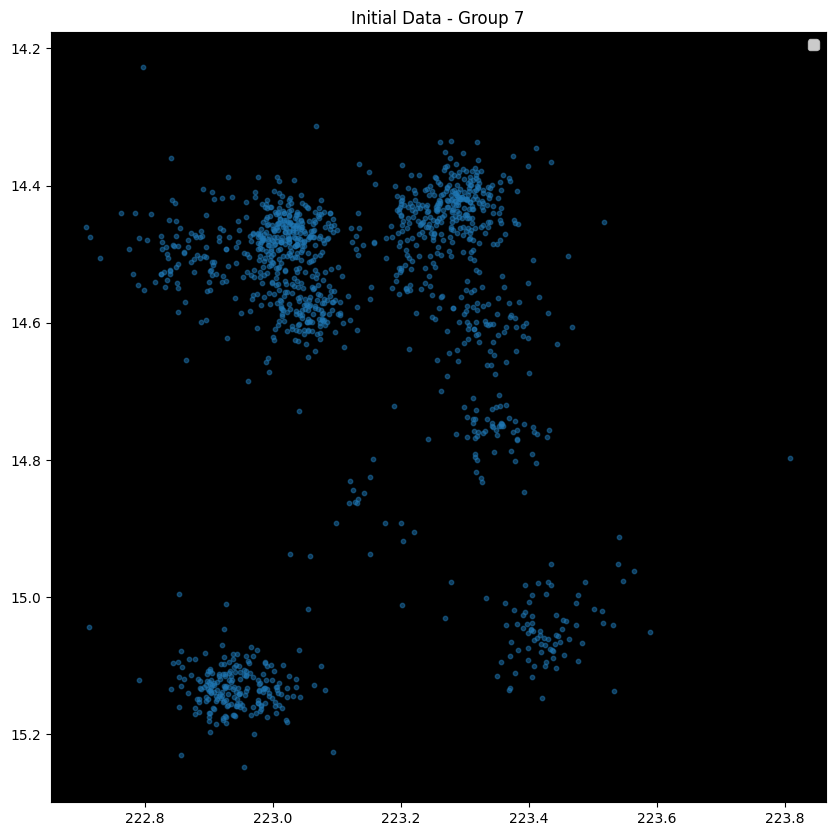

K-Means labels:
 [6 6 6 ... 1 0 4]


/tmp/ipykernel_3018/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


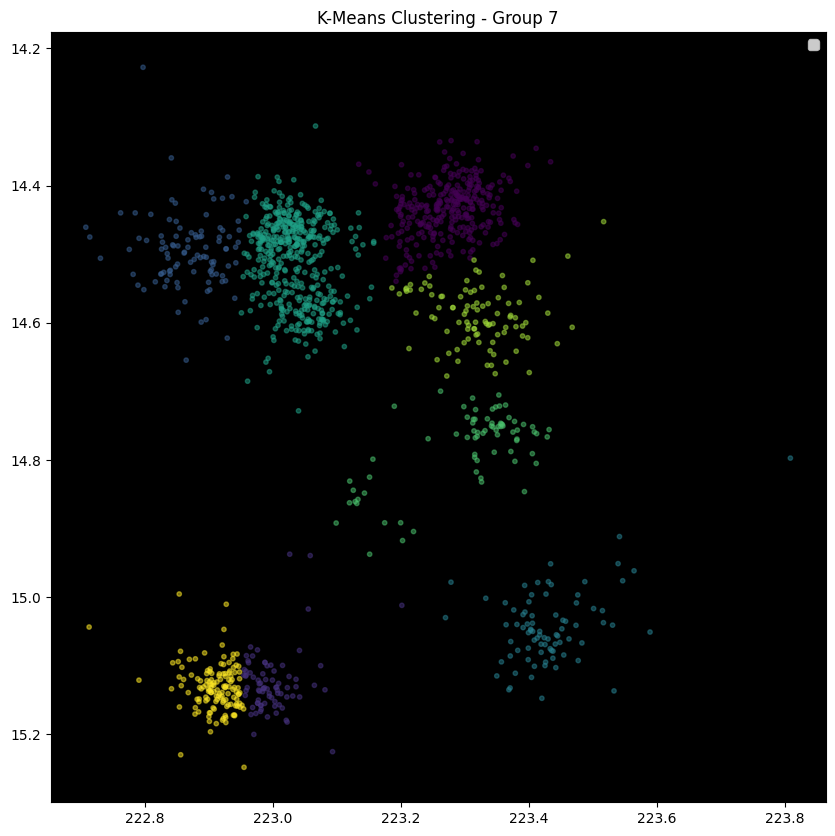

Centers of Mass (COM):
 [(np.float64(223.27507596950593), np.float64(14.433844281193426)), (np.float64(222.99846229553222), np.float64(15.125154447555541)), (np.float64(222.86796373423962), np.float64(14.494447273783164)), (np.float64(223.43251112949702), np.float64(15.04354229679814)), (np.float64(223.0340471157576), np.float64(14.510466890577355)), (np.float64(223.30488359605943), np.float64(14.781124321190086)), (np.float64(223.31949944747123), np.float64(14.588269856101588)), (np.float64(222.90961416739006), np.float64(15.131903923882378))]


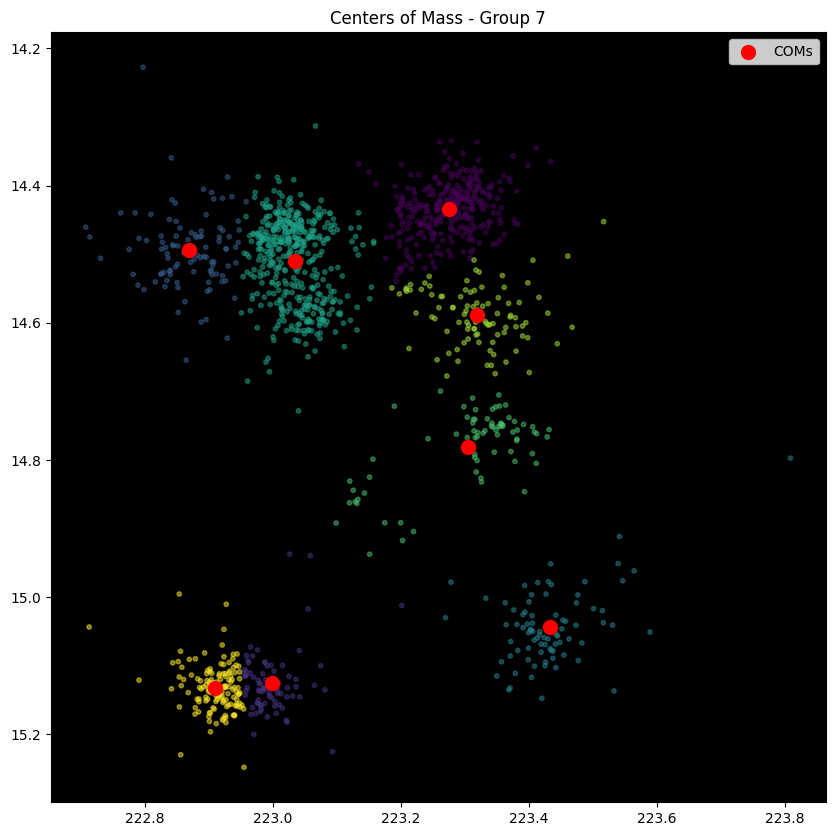

Minimum Bounding Rectangle:
 [[223.43498681  15.06017312]
 [223.34030563  14.42413415]
 [222.81587619  14.50220106]
 [222.91055736  15.13824003]]
Closest side of bounding rectangle:
 0
Rotation angle:
 4.860164464955311
Rotated Data:
 [[222.94313544  15.03762239]
 [222.97724001  15.04802151]
 [222.94031074  15.00627092]
 [222.97373134  15.03188716]
 [223.01128999  14.98777261]]
Rotated Centers of Mass (COM):
 [[222.7919393   15.12612155]
 [223.43498681  15.50150771]
 [222.7919393   15.53771977]
 [223.41817272  15.06017312]
 [222.83223814  15.37580522]
 [223.13982317  15.1477717 ]
 [222.95122263  15.10491959]
 [223.42858088  15.59038127]]


/tmp/ipykernel_3018/2632525597.py:89: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


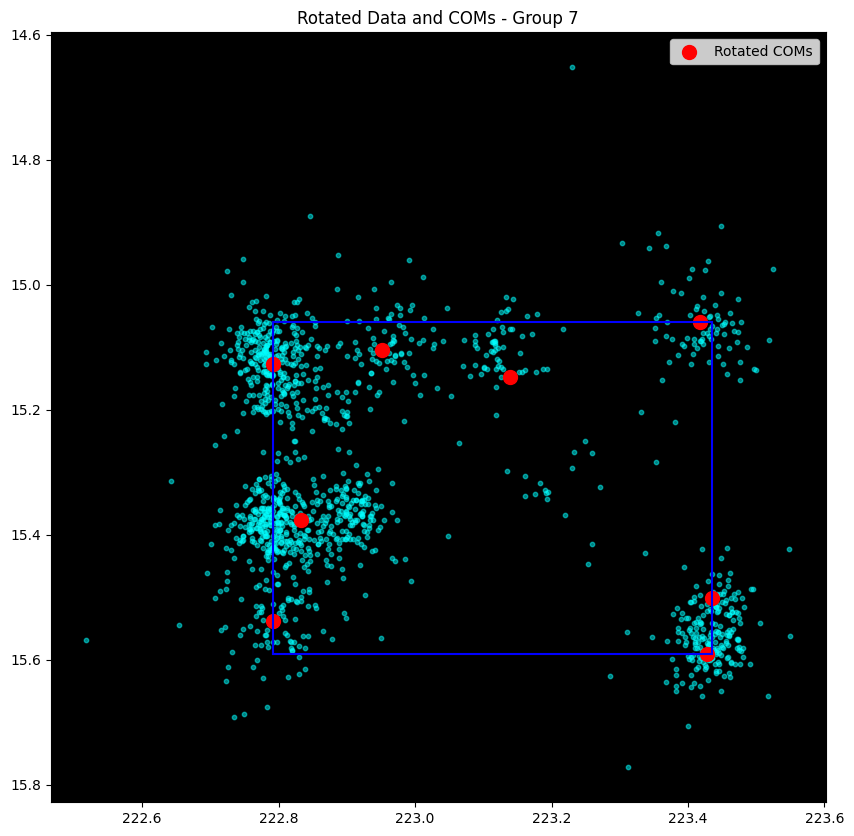

Second Highest COM:
 [222.83223814  15.37580522]
Right Most COM:
 [223.43498681  15.50150771]
Second Right Most COM:
 [223.42858088  15.59038127]
Robot COM:
 [223.13982317  15.1477717 ]


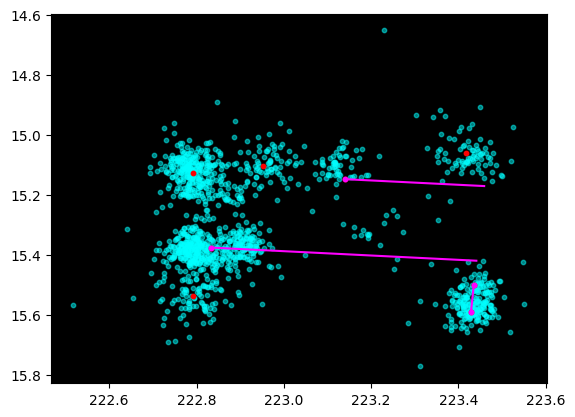

Ratio:
 0.5241186537035032

Processing Group 8
Data collected:
             x         y
0  237.977173  6.251901
1  238.027069  6.185611
2  238.016663  6.100646
3  238.483246  5.802577
4  238.440857  5.771270


/tmp/ipykernel_3018/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


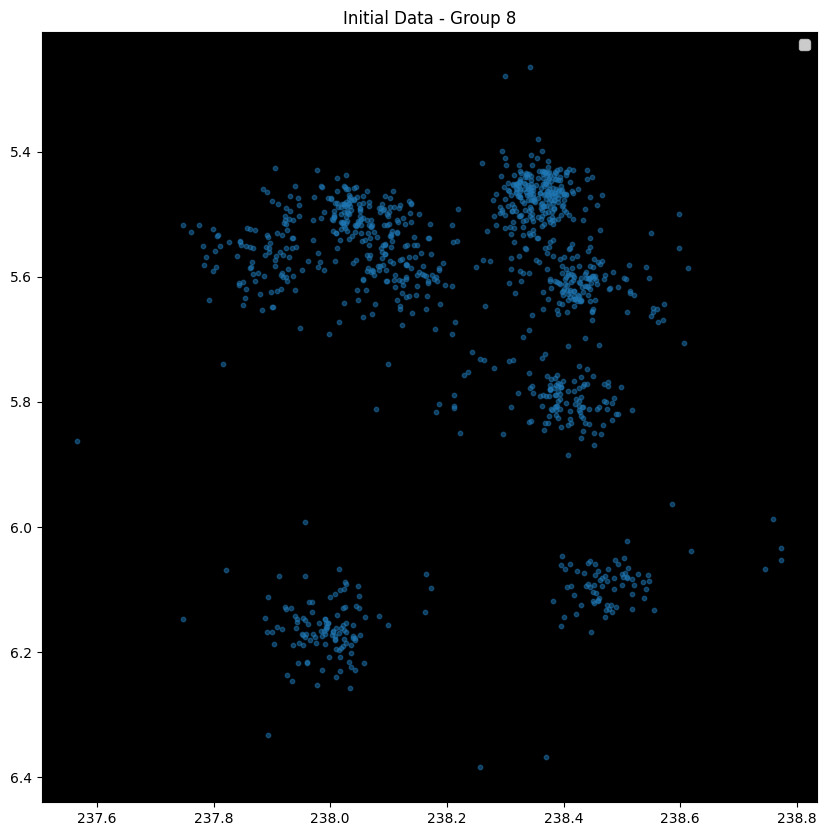

K-Means labels:
 [2 2 2 ... 6 6 6]


/tmp/ipykernel_3018/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


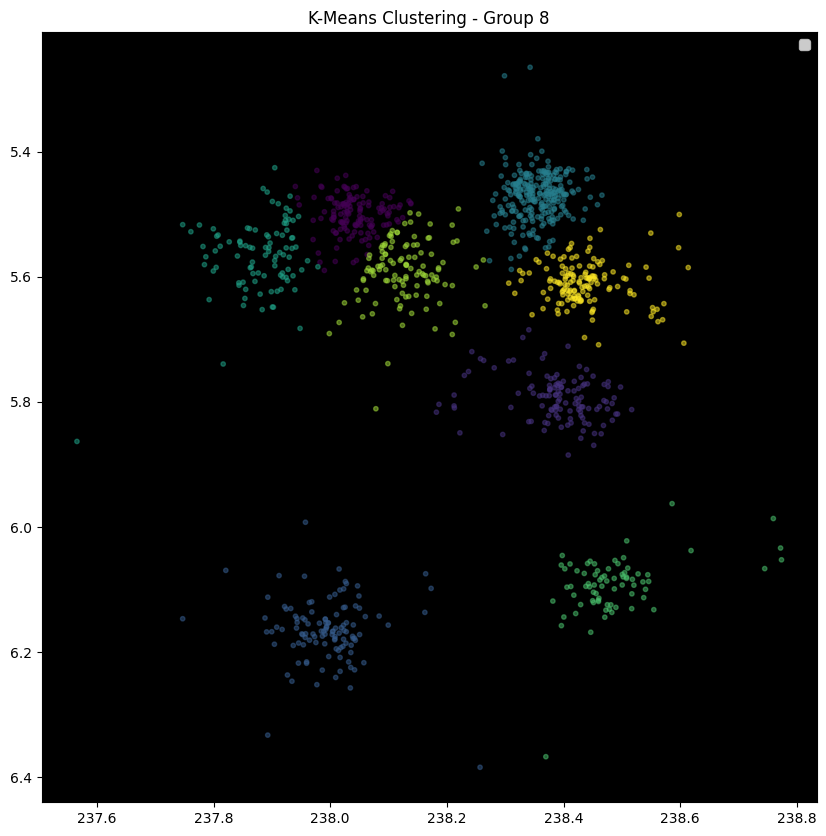

Centers of Mass (COM):
 [(np.float64(238.0415244342612), np.float64(5.500701331406188)), (np.float64(238.3882244519951), np.float64(5.793326519737559)), (np.float64(237.99338153341543), np.float64(6.164132669697637)), (np.float64(238.3551462809245), np.float64(5.471050802866618)), (np.float64(237.87888842130963), np.float64(5.566739684657047)), (np.float64(238.48725077311198), np.float64(6.092408180236816)), (np.float64(238.1275266450027), np.float64(5.592348830453281)), (np.float64(238.4365927956321), np.float64(5.611138427174175))]


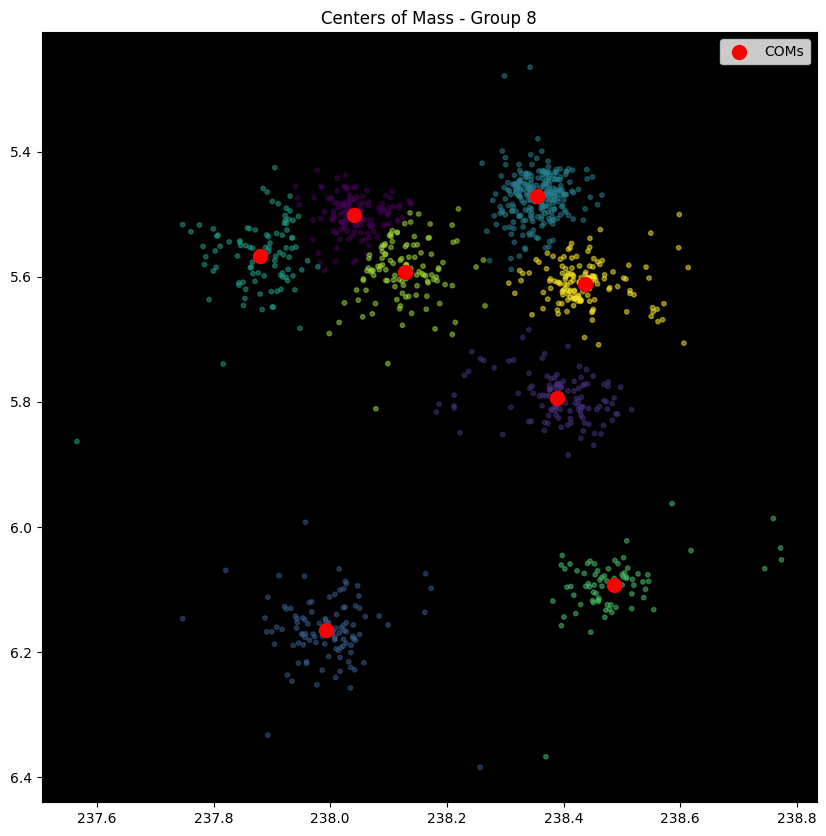

Minimum Bounding Rectangle:
 [[238.52735719   6.0847216 ]
 [238.40217962   5.43158011]
 [237.8724425    5.53310666]
 [237.99762007   6.18624816]]
Closest side of bounding rectangle:
 1
Rotation angle:
 0.18935840846052354
Rotated Data:
 [[237.8303618    6.15723909]
 [237.89184382   6.10152602]
 [237.89761625   6.01612072]
 [238.41196441   5.81120499]
 [238.37622611   5.77247857]]
Rotated Centers of Mass (COM):
 [[238.03496047   5.43158011]
 [238.3203828    5.78423361]
 [237.86280122   6.07409086]
 [238.34855747   5.46149224]
 [237.86280122   5.46582526]
 [238.36134326   6.09660886]
 [238.10217471   5.53777752]
 [238.40217962   5.61440641]]


/tmp/ipykernel_3018/2632525597.py:89: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


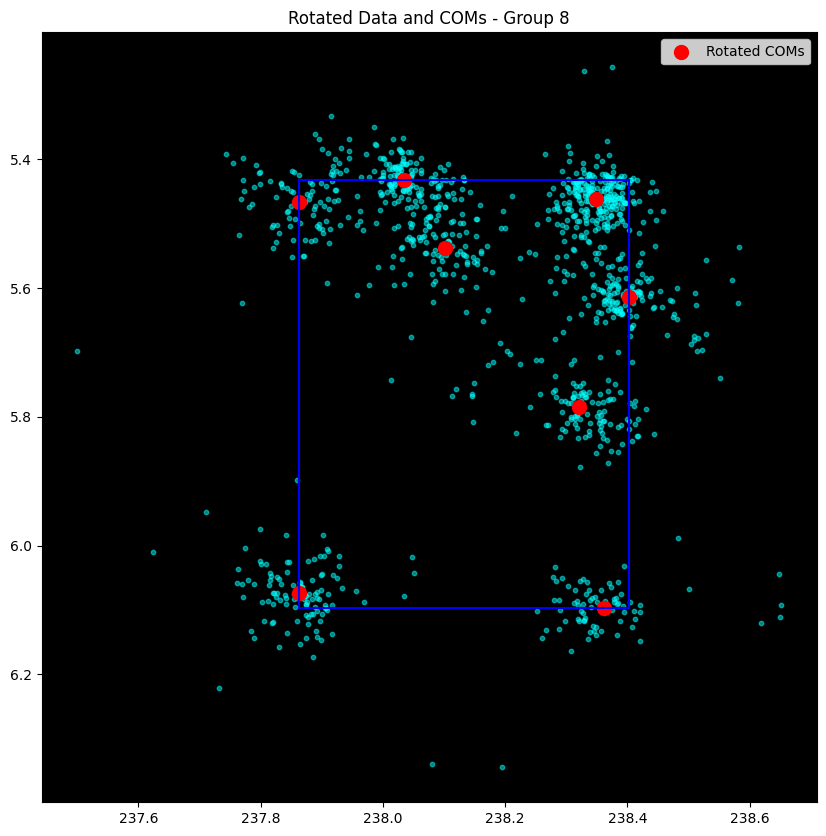

Second Highest COM:
 [237.86280122   5.46582526]
Right Most COM:
 [238.40217962   5.61440641]
Second Right Most COM:
 [238.36134326   6.09660886]
Robot COM:
 [238.10217471   5.53777752]


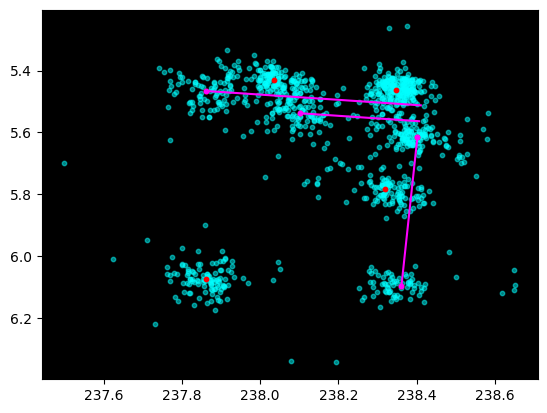

Ratio:
 0.555282384875596

Processing Group 9
Data collected:
             x          y
0  204.727203  23.444227
1  204.673523  23.472221
2  204.732361  23.457150
3  204.768372  23.501686
4  205.214050  22.981375


/tmp/ipykernel_3018/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


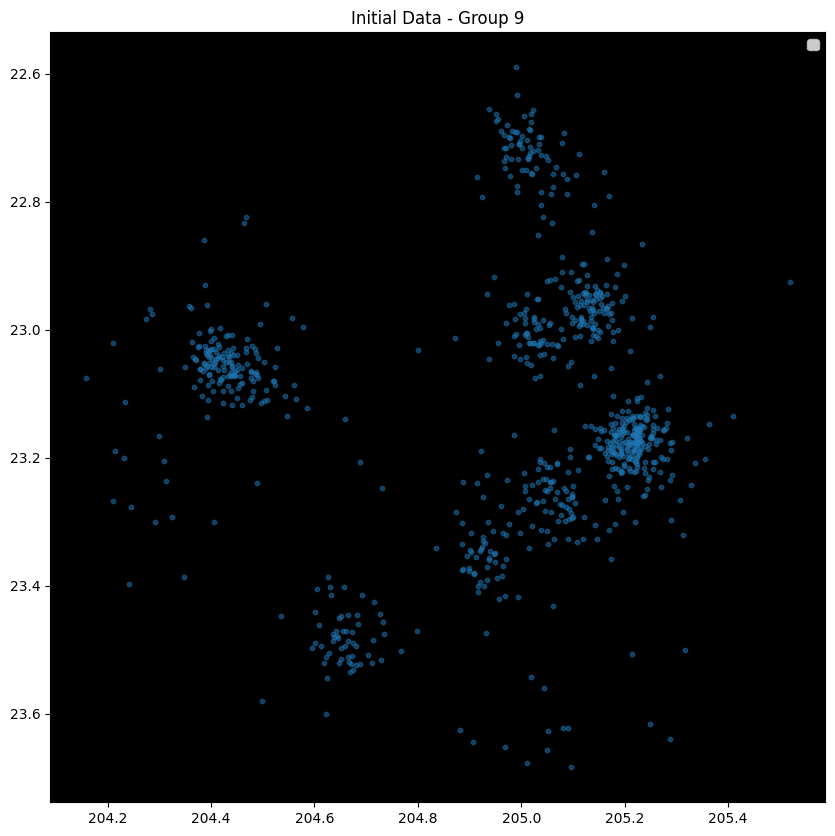

K-Means labels:
 [3 3 3 3 2 2 2 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 1 5 5 5 5 5 5 5 5 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 7 0 0 7 7 5 3 3 3 5 5 5 5 5 5 5 0 0 0 0
 0 0 0 0 2 2 7 5 1 5 1 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 5 5 5 5 5 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 6 3 3 3 3 3 3 3 3 3 3 6 3 5 6 6 6 6
 6 6 6 6 6 6 6 6 2 2 2 7 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 4 0 7
 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 7 7 7 4 2 2 2 2 2 2 2 0 7 7 4 4 3 3 2 2 2 1
 1 0 0 0 0 0 0 0 0 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 3 1 1 7 2 2 3 3 3 3 0 0 0 0 0 0 0 4 4 4 3 3 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 4 4 4 3 3 3 4 4 4 4 4 5 5 5 5 7 7 1 1 1 1 7 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 7 0 0 0 0 0 0 1 5 1 1 5 5 5 5 5 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 2 2 5 1 5 7 7 0 0 0 0 0
 0 0 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 4 4 4 4 4 4
 4 4 4 4

/tmp/ipykernel_3018/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


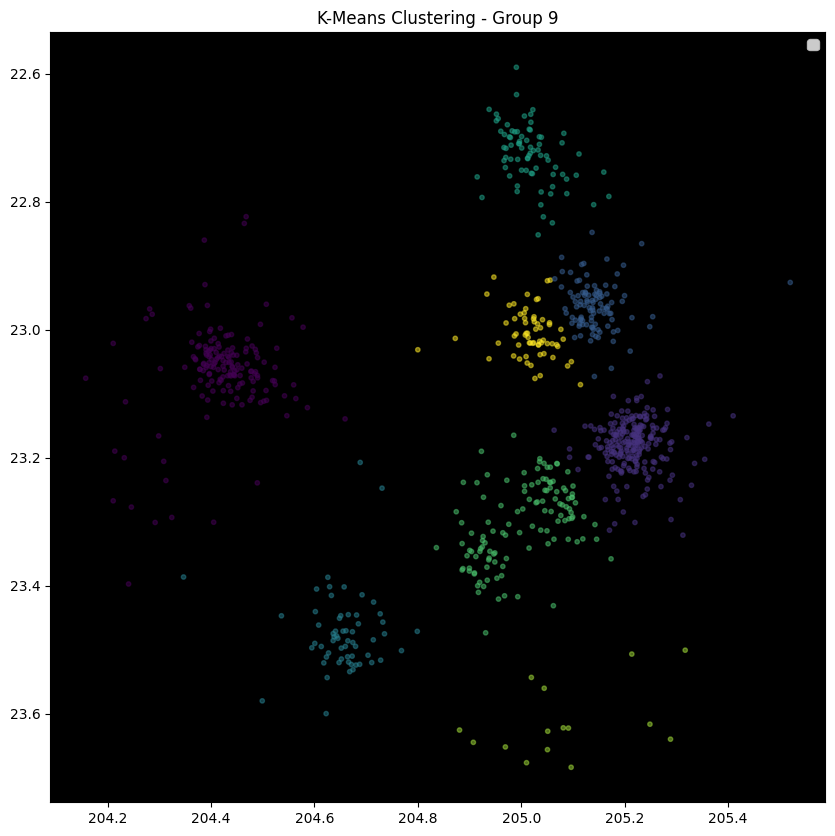

Centers of Mass (COM):
 [(np.float64(204.42058107329578), np.float64(23.06531200176332)), (np.float64(205.21581578887668), np.float64(23.18072496262272)), (np.float64(205.14419389479232), np.float64(22.96297577584144)), (np.float64(204.65483907063802), np.float64(23.473085753122966)), (np.float64(205.01724604556435), np.float64(22.726969543256256)), (np.float64(205.00301615397134), np.float64(23.30264770189921)), (np.float64(205.08466186523438), np.float64(23.61215985616048)), (np.float64(205.0172770023346), np.float64(23.006676703691483))]


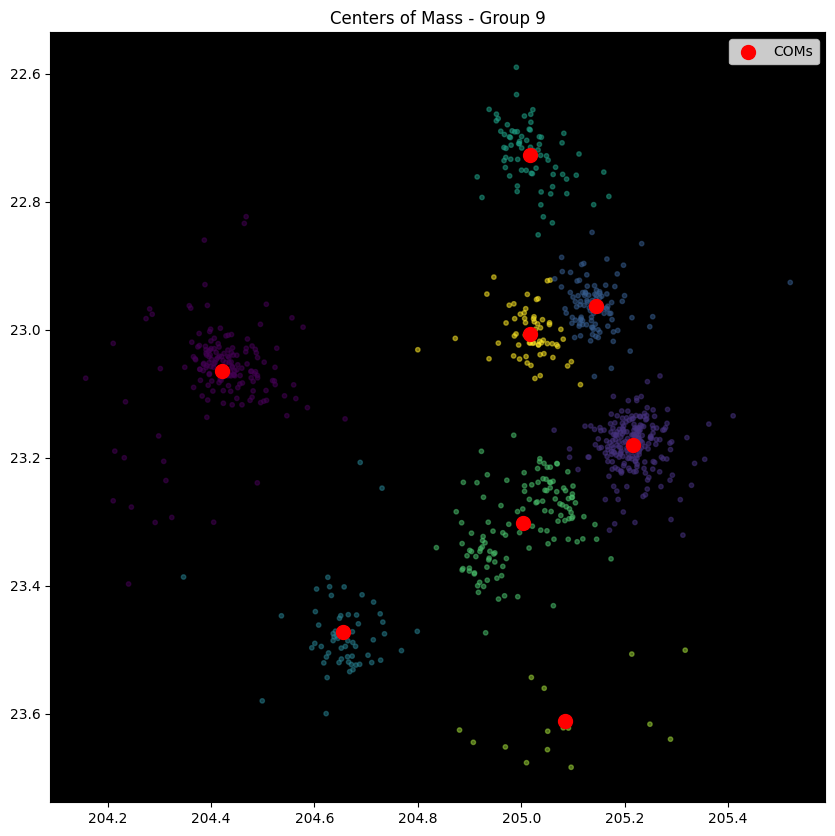

Minimum Bounding Rectangle:
 [[205.41346958  23.42570746]
 [205.01724605  22.72696954]
 [204.42058107  23.065312  ]
 [204.81680461  23.76404992]]
Closest side of bounding rectangle:
 0
Rotation angle:
 5.228232647658167
Rotated Data:
 [[205.0910657   24.03180979]
 [205.08893829  24.0923138 ]
 [205.10485052  24.03369759]
 [205.16135485  24.0243412 ]
 [204.92858749  23.38000217]]
Rotated Centers of Mass (COM):
 [[204.61020887  24.11162634]
 [205.1028685   23.47679968]
 [204.87812466  23.431693  ]
 [205.08047401  24.10899284]
 [204.61020887  23.42570746]
 [205.10395883  23.72204986]
 [205.41346958  23.80370086]
 [204.85353493  23.56365138]]


/tmp/ipykernel_3018/2632525597.py:89: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


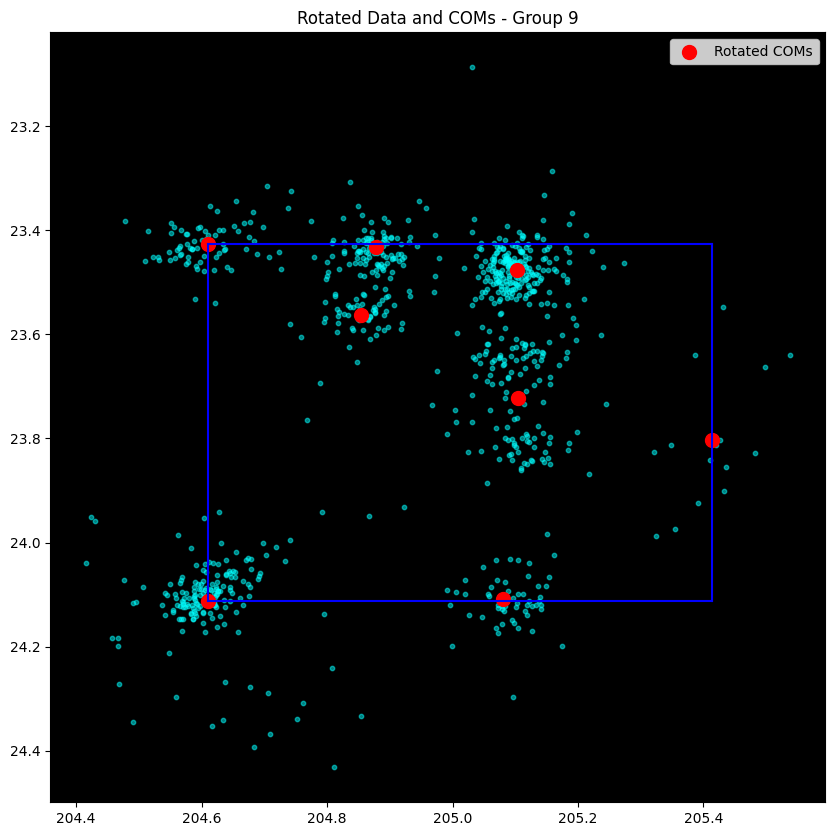

Second Highest COM:
 [204.85353493  23.56365138]
Right Most COM:
 [205.41346958  23.80370086]
Second Right Most COM:
 [205.10395883  23.72204986]
Robot COM:
 [205.10395883  23.72204986]


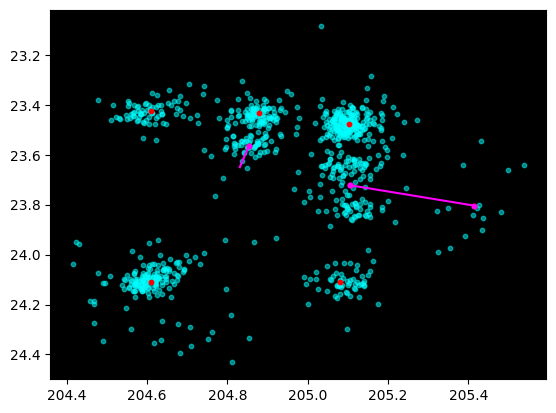

Ratio:
 0.0


np.float64(0.0)

In [157]:
# Example usage
filename = 'data/n=10_origmi_locs.hdf5'
k = 8
process_multiple_origami_ratio(filename, k)

Starting process_origami_ratio
Data collected:
             x          y
0  111.875267  60.029800
1  111.827614  60.045071
2  111.803627  60.154224
3  111.851440  60.342262
4  111.837921  60.320156


/tmp/ipykernel_3018/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


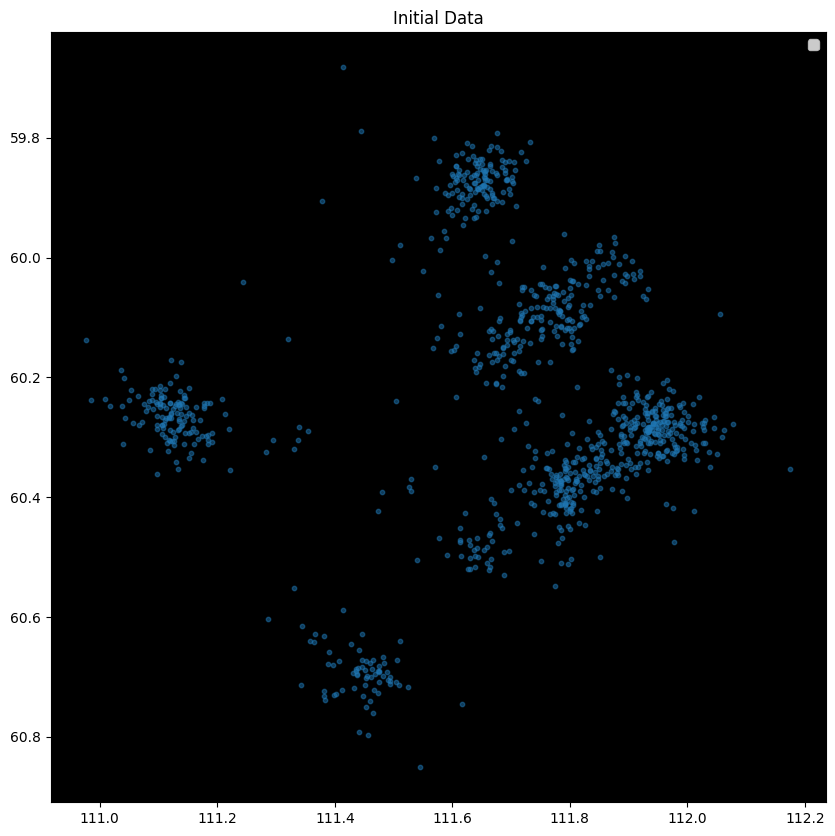

K-Means labels:
 [1 1 1 3 3 7 7 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 1 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 1 1 1 1 1 1 1 1 7 1 1 1 1 7 7 1 1 1 7 2 2 2 2 1
 1 1 1 1 1 1 1 1 1 1 4 4 4 5 5 5 5 5 3 3 4 4 4 4 4 4 4 4 4 4 4 1 1 1 1 7 3
 3 6 6 6 6 6 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 6 6 6 0 3 6 6 6 6 6 6 6 6 6 6 6 7 3 3 6 6 0 2 6 6 4 4 4 4 2 2 3
 3 3 3 2 4 4 3 3 3 3 3 3 6 6 3 3 2 2 2 2 2 2 4 7 7 3 3 6 6 6 6 6 6 6 3 6 3
 6 3 3 3 3 3 3 3 1 7 7 7 7 7 7 7 7 7 7 1 1 1 1 3 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 3 3 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 4 4 4 4 0 0 3 0 0 0 0 1
 1 4 4 4 2 2 2 2 2 2 2 1 1 7 7 7 6 6 6 0 0 0 0 0 0 0 0 0 2 2 2 2 2 7 2 2 2
 2 4 7 3 3 0 0 0 0 0 0 0 0 0 0 0 0 5 5 4 4 4 4 4 4 4 7 7 7 7 7 7 0 4 6 6 6
 3 3 3 7 7 7 7 4 4 4 4 4 4 4 4 4 4 2 4 1 1 1 1 1 1 5 5 5 5 2 6 6 6 6 6 5 5
 4 7 1 1 1 0 3 3 7 2 2 3 3 3 3 6 6 2 2 1 4 4 4 4 4 5 5 5 5 5 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 4 1 6 6 6 6 7 7
 7 7 7 0

/tmp/ipykernel_3018/828579105.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


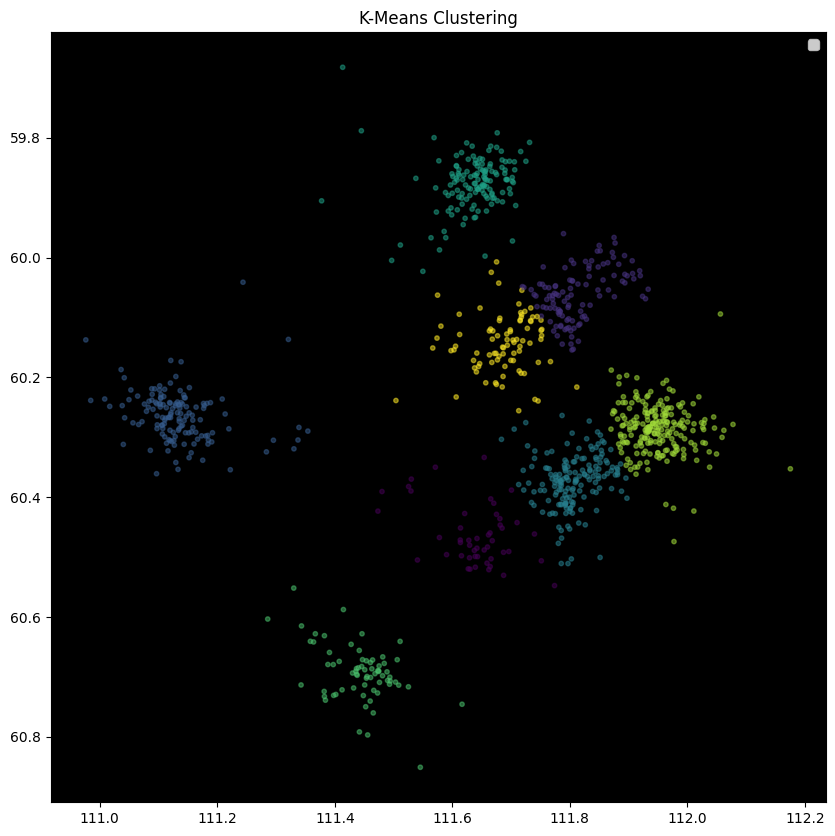

Centers of Mass (COM):
 [(np.float32(111.6388), np.float32(60.46383)), (np.float32(111.81368), np.float32(60.061646)), (np.float32(111.1327), np.float32(60.26338)), (np.float32(111.805565), np.float32(60.373165)), (np.float32(111.63653), np.float32(59.876465)), (np.float32(111.443954), np.float32(60.693012)), (np.float32(111.95023), np.float32(60.285942)), (np.float32(111.68582), np.float32(60.143295))]


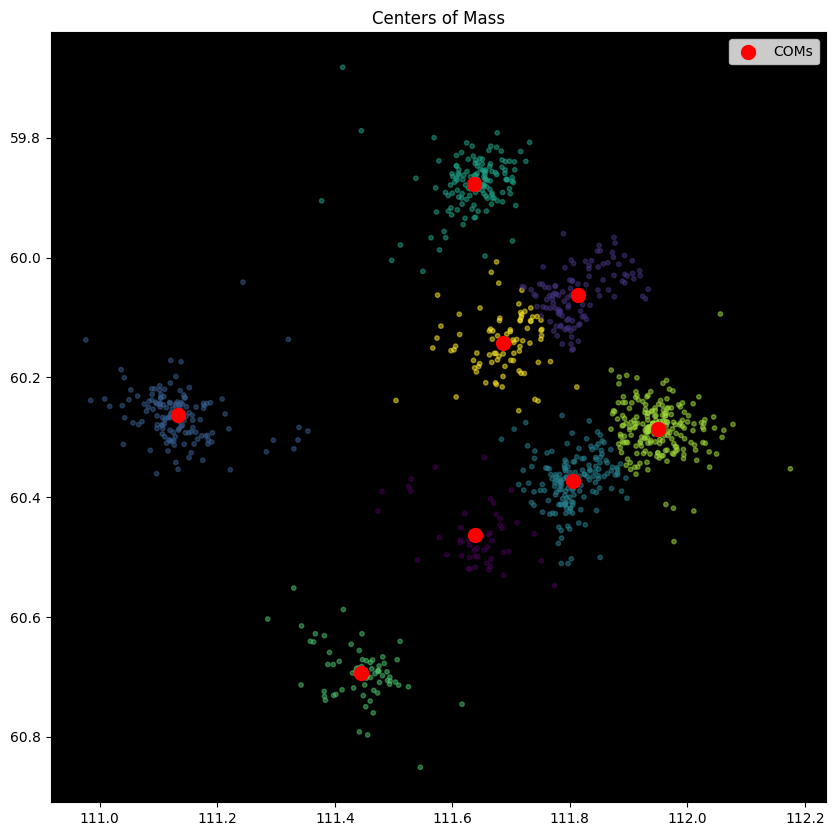

Minimum Bounding Rectangle:
 [[111.98150635  60.28019714]
 [111.65850067  59.85958099]
 [111.12094116  60.2723999 ]
 [111.44394684  60.69301605]]
Closest side of bounding rectangle:
 3
Rotation angle:
 3.796483232570589
Rotated Data:
 [[110.69791413  60.95631679]
 [110.74500925  60.97323   ]
 [110.83051609  60.90126828]
 [110.90712326  60.72301087]
 [110.90438134  60.74877782]]
Rotated Centers of Mass (COM):
 [[111.14981321  60.75610696]
 [110.76615364  60.96856939]
 [111.42912216  61.2233412 ]
 [110.96232991  60.72644289]
 [110.79386904  61.22333883]
 [111.44393846  60.69301443]
 [110.79446599  60.70750712]
 [110.91729271  60.98168839]]


/tmp/ipykernel_3018/2632525597.py:89: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


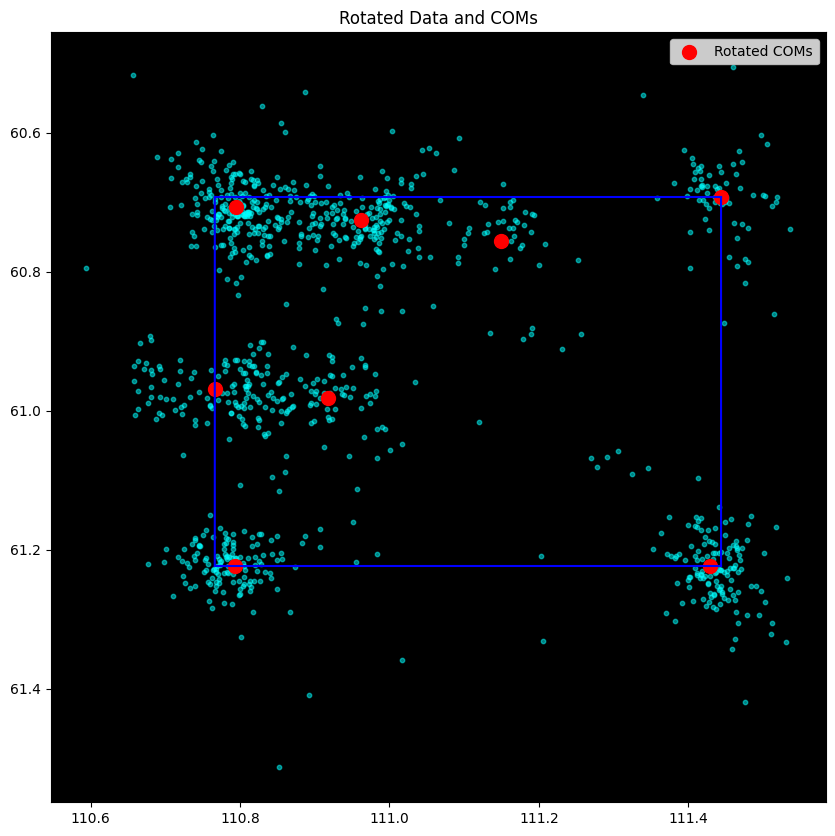

Second Highest COM:
 [110.76615364  60.96856939]
Right Most COM:
 [111.44393846  60.69301443]
Second Right Most COM:
 [111.42912216  61.2233412 ]
Robot COM:
 [110.91729271  60.98168839]


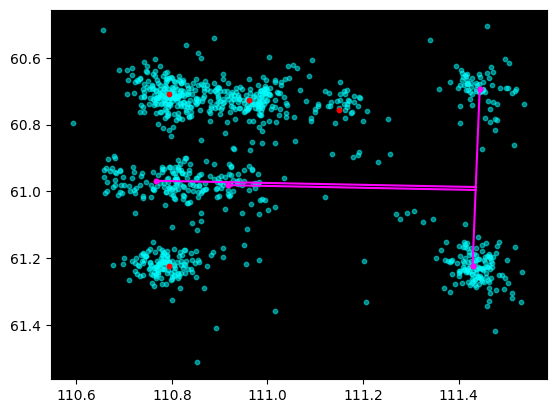

Ratio:
 0.7739013901824149
0.7739013901824149


In [134]:
#testing
ratio = process_origami_ratio('data/test_1.hdf5', 8)
print(ratio)